# Volatility Forecasting Using Spectral Features and Deep Learning

This notebook implements a complete pipeline for forecasting short-horizon realized volatility using:

- Time–frequency representations of financial returns
- Deep learning architectures (TCN, LSTM)
- Classical econometric baselines (GARCH, HAR-RV)
- Evaluation with MSE and QLIKE


The notebook follows the full project structure described in the accompanying write-up.

---

# 0. Introduction and Literature Context

This project is positioned at the intersection of the **course material on signal processing** and the **financial econometrics literature on volatility modeling and forecasting**. The methodological choices made throughout the project are directly motivated either by concepts introduced in the lectures or by closely related ideas developed in recent academic work.

## 0.1 Link with the Course Material

In this project, financial volatility time series are treated as **signals evolving over time**, in line with the perspective adopted throughout the course. The main connection with the course material lies in the use of **deep learning architectures for sequential data**, rather than in the explicit use of handcrafted signal transformations.

The deep learning models considered in this work (MLP applied to temporal windows, LSTM, and temporal convolutional networks) are directly inspired by the architectures studied in the lectures. These models operate on time-domain signals and are designed to capture temporal dependence, persistence, and multi-scale dynamics, which are key characteristics of financial volatility series.

As such, this project applies the deep learning tools introduced in the course to a financial time-series setting, viewing volatility as a signal whose structure evolves over time and can be learned from past observations using appropriate neural architectures.


## 0.2 Brief Literature Context

In financial econometrics, volatility forecasting has traditionally relied on parametric and semi-parametric models such as **GARCH** and **HAR-RV**, which capture persistence and multi-scale effects in volatility dynamics. These models serve as standard benchmarks and motivate the use of lagged volatility measures as predictive inputs.

More recent studies explore the use of **nonlinear and data-driven models** for volatility forecasting. For instance:

- **Sirignano and Cont (2019)** highlight the presence of stable nonlinear structures in high-frequency financial data, suggesting limitations of purely linear modeling approaches.

- **Zhang, Zohren, and Roberts (DeepLOB)** demonstrate that deep architectures can learn hierarchical temporal representations from financial time series.

- **Moreno-Pino and Zohren (2022, DeepVol)** show that deep learning models applied to realized volatility measures can outperform classical benchmarks when carefully designed.

These works motivate the exploration of richer representations and nonlinear models, while still relying on realized volatility as a core object of interest.

## 0.3 Scope of the Present Work

Following the lecture notes and the referenced literature, this project adopts the following approach:

- realized volatility measures are used as primary signals to be forecast,
- classical econometric models (GARCH, HAR-RV) are used as baselines,
- deep learning models are investigated as flexible nonlinear predictors,


This framework ensures a direct connection between the **course material** and **modern volatility forecasting methods**, in line with the objectives of the project.


# 1. What Is Volatility? Intuition, Mathematical Formulation, and Purpose

## 1.1 Intuitive Meaning of Volatility

Volatility is a numerical measure of how much the price of a financial asset (such as a stock index, currency, commodity, or bond) fluctuates over time.  
It represents the **degree of uncertainty**, **variability**, or **risk** in the asset's returns.

- If an asset’s price changes slowly and steadily → **low volatility**  
- If an asset’s price jumps rapidly or frequently → **high volatility**

In financial markets, volatility plays a critical role because it quantifies **risk**, one of the central concepts in finance.

---

## 1.2 Why Is Volatility Important?

Volatility is essential in nearly every domain of financial decision-making:

### (i) **Risk Management**
Institutions measure the risk of losing money using volatility.  
Higher volatility implies larger possible losses.

### (ii) **Option Pricing**
The famous Black–Scholes formula requires volatility as a key input.  
Option prices increase when volatility increases. However it assumes that the volatily is constant in time, which prevent this framework to be universal.  

### (iii) **Portfolio Management**
Investors allocate capital based partly on volatility.  
Risk-adjusted performance metrics such as Sharpe Ratio explicitly depend on volatility.

### (iv) **Trading and Execution**
Short-term traders rely on volatility forecasts to adjust:
- position sizes,
- stop-loss levels,
- order execution strategies.

### (v) **Market Microstructure Analysis**

In high-frequency financial data, the observed asset price does not coincide with the latent **efficient price** that reflects the true economic value of the asset. Instead, the observed price is affected by market microstructure effects arising from the trading mechanism itself.

Formally, the observed log-price can be decomposed as
$
\log P_t \;=\; \log P_t^{\ast} + \varepsilon_t,
$
where $P_t^{\ast}$ denotes the efficient price process and $\varepsilon_t$ represents the **microstructure noise**.

**In summary**:  
Predicting volatility means predicting future market risk, which is extremely valuable.

---

# 2. How Is Volatility Determined? Parameters and Calculation Methods

Volatility is not directly observable : it is a latent parameter. Thus, it must be **estimated** from price data !  

There are several approaches, each with different assumptions and levels of precision.

---

## 2.1 Returns as the Fundamental Input

Let $P_t$ be the asset price.  
We define the log-return:

$$
r_t = \log(P_t) - \log(P_{t-1}).
$$

Returns are preferred over raw prices because they:

- remove scale effects,
- approximately follow a stationary distribution,
- allow additive time aggregation.

---

## 2.2 Historical Volatility

Let  
- $P_t$ be the asset price at time $t$  
- $r_t = \log(P_t) - \log(P_{t-1})$ be the **log-return**  

Then over a period of $n$ observations, the **historical volatility** $\sigma$ is defined as :

$$
\sigma^2 = \frac{1}{n} \sum_{t=1}^{n} (r_t - \bar r)^2.
$$

Limitations:
- uses only daily data,
- treats all days equally,
- ignores intraday patterns : huge loss of information.
---

## 2.3 Realized Volatility (High-frequency Approach)

Therefore, we us intraday data (e.g., 5-minute prices).

Let $r_{t,i}$ be the $i$-th intraday return on day $t$.  

These are computed from high-frequency intraday returns  
$ r_{t,i} = \log(P_{t,i}) - \log(P_{t,i-1}) $,  
where $i$ indexes intraday intervals.

Let a trading day contain $M$ intraday returns. Then the basic **realized variance** is:

$$
RV_t = \sum_{i=1}^{M} r_{t,i}^2.
$$

Realized variance is a **nonparametric estimator of daily volatility** and is a core tool in modern financial econometrics.

Then the realized volatility is defined as :

$$
\sigma_t = \sqrt{RV_t}.
$$

Advantages:
- much more accurate,
- converges to the true integrated volatility in continuous-time finance models,
- widely used in both academia and industry.

This is the type of volatility our **Oxford-Man dataset** provides.

The $RV$ estimator is designed to estimate the **integrated variance** and is consistent, converging towards :
$$
\int_t^{t+1} \sigma_s^2\, ds,
$$
which measures the **total volatility accumulated over the day**.

---

## 2.4 Parametric Volatility Models for Baseline

We consider two standard parametric volatility models, estimated independently for each symbol and used as benchmarks.

---

### GARCH(1,1)

Let $r_t^{(s)}$ denote the daily log-return of symbol $s$. Returns are modeled as

$$
r_t^{(s)} = \mu^{(s)} + \varepsilon_t^{(s)}, \qquad
\varepsilon_t^{(s)} = \sigma_t^{(s)} z_t^{(s)}, \quad z_t^{(s)} \sim \mathbf{N}(0,1).
$$

The conditional variance follows a GARCH(1,1) recursion:

$$
\sigma_{t+1}^{2,(s)}
=
\omega^{(s)}
+ \alpha^{(s)} \left(\varepsilon_t^{(s)}\right)^2
+ \beta^{(s)} \sigma_t^{2,(s)}.
$$

The one-step-ahead forecast $\hat{\sigma}_{t+1}^{2,(s)}$ is used as a proxy for next-day realized variance.

---

### HAR-RV

Let $x_t^{(s)} = \log(RV_t^{(s)})$ denote log-realized variance. The HAR-RV model is given by

$$
x_{t+1}^{(s)}
=
\beta_0^{(s)}
+ \beta_d^{(s)} x_t^{(s)}
+ \beta_w^{(s)} \bar{x}_{t:t-4}^{(s)}
+ \beta_m^{(s)} \bar{x}_{t:t-21}^{(s)}
+ \varepsilon_{t+1}^{(s)},
$$

where

$$
\bar{x}_{t:t-4}^{(s)} = \frac{1}{5} \sum_{i=0}^{4} x_{t-i}^{(s)},
\qquad
\bar{x}_{t:t-21}^{(s)} = \frac{1}{22} \sum_{i=0}^{21} x_{t-i}^{(s)}.
$$

HAR-RV captures volatility persistence across daily, weekly, and monthly horizons.

---

Both models serve as baseline benchmarks for comparison with deep learning approaches.


---

# 3. The Oxford-Man Realized Volatility Dataset

The dataset we use is the **Oxford-Man Realized Volatility Dataset**, a widely used academic dataset providing high-frequency–based volatility measures for many financial instruments.  
It spans **January 2000 to approximately June 2018**, covering **multiple assets (symbols)** such as equity indices, stocks, FX pairs, and commodities.

A crucial structural property of the dataset is:

**Each row corresponds to one trading day for one symbol (asset).**

Thus, the dataset is a **panel time series**:  
- multiple daily observations,  
- across multiple assets,  
- each observation containing several realized measures computed from high-frequency intraday data.

Below, we explain **every feature** in the dataset, what it represents, and why it is relevant.

---

# 3.1 Overview of the Dataset Features

The following columns are present:

Date, Symbol, open_time, close_time, open_price, close_price,
rv5_ss, rv10_ss, rv10, bv, bv_ss, medrv, rsv, rsv_ss,
rk_parzen, rk_twoscale, rk_th2, nobs, open_to_close, rv5



Each feature is explained below.

---

# 3.2 Time and Price Information

### **(1) `Date`**
The trading-day date for the observation.  
Each row = the data for **one day** for **one asset**.

### **(2) `Symbol`**
The asset identifier (e.g., SPX, FTSE, DAX, AAPL).  
The dataset contains **many symbols observed over many days**.

### **(3) `open_time`**
Timestamp of the first intraday observation used for that day’s realized-measure calculations.

### **(4) `close_time`**
Timestamp of the last intraday observation used for that day’s realized-measure calculations.

### **(5) `open_price`**
The asset's price at the start of the trading day.

### **(6) `close_price`**
The asset’s price at the end of the trading day.

From these, we may compute **log-returns**:

$$
r_t = \log(\text{close_price}_t) - \log(\text{close_price}_{t-1}).
$$

We use returns as part of our signal-processing pipeline.

---

# 3.3 Realized Variance Measures (High-Frequency Based)


### **(7) `rv5_ss` — 5-minute subsampled realized variance**

`rv5_ss` is the **primary** realized variance estimator in the dataset.  
It is constructed from **intraday returns sampled every 5 minutes**, combined with a **subsampling procedure** to reduce microstructure noise.

#### Why 5-minute returns?
High-frequency prices contain noise (bid–ask bounce, discreteness, asynchronous trading).  
Using approximately 5-minute spacing strikes a balance:
- high enough frequency to capture intraday volatility,
- low enough frequency to avoid most microstructure distortions.


#### What is subsampling, in simple terms?
If we take returns every 5 minutes, we normally choose one set of timestamps, for example:

- 9:30 → 9:35 → 9:40 → 9:45 → …

But this starting time (9:30) is arbitrary.  
If we shift it slightly, we get another valid 5-minute grid:

- 9:31 → 9:36 → 9:41 → …

Each grid produces its own realized variance for the same day.  
These values differ slightly because prices move continuously and each grid captures different small fluctuations.

**Subsampling means computing realized variance on several such shifted 5-minute grids and then averaging the results.**

Formally, if there are $K$ shifted grids, the subsampled realized variance is
$$
RV_t^{\text{sub}} = \frac{1}{K} \sum_{k=1}^{K} RV_t^{(k)},
$$
where each $RV_t^{(k)}$ is the standard realized variance on grid $k$.

Averaging across grids reduces random noise caused by any single arbitrary choice of timestamps.

#### Interpretation
Higher values of `rv5_ss` indicate stronger price movements throughout the day,  
meaning **higher volatility**.

---

### **(8) `rv10_ss`**
Realized variance based on **10-minute** intraday returns with subsampling.  
A smoother, lower-noise alternative to 5-minute sampling.

### **(9) `rv10`**
Realized variance using **all** 10-minute returns without subsampling.

### **(10) `rv5`**
Realized variance using **all 5-minute** returns without subsampling.

These variations allow practitioners to trade off noise reduction vs. accuracy.

---

# 3.4 Bipower Variation (Continuous Component of Volatility)

High-frequency price processes have two types of variability:
1. **Continuous variation** (Brownian-like movement)
2. **Jump variation** (sudden discrete jumps)

Bipower variation estimates only the continuous component.

Given intraday returns:

$$
BV_t = {\frac{\pi}{2}} \sum_{i=2}^{M} |r_{t,i}|\, |r_{t,i-1}|.
$$


Dataset columns include:

### **(11) `bv`**
Standard bipower variation estimator.

### **(12) `bv_ss`**
Subsampled bipower variation for improved robustness.

Interpretation:  
- Large `bv` indicates high continuous variability.  
- If $RV_t - BV_t$ is large, the day likely contains **jumps**.

---

# 3.5 Median Realized Variance (Jump-Robust)

### **(13) `medrv`**
The **median realized variance**, a robust estimator that reduces sensitivity to extreme returns or market microstructure noise.

Defined approximately as:

$$
\text{MedRV}_t
= \frac{\pi}{6 - 4\sqrt{3}}
\left( \text{median}_i(|r_{t,i}|, |r_{t,i+1}|, |r_{t,i+2}|) \right)^2.
$$

Use-case: jump-robust estimation.

---

# 3.6 Realized Semivariance (Upward and Downward Volatility)

Semivariance separates positive and negative return contributions.

Let:

- $r_{t,i}^+ = \max(r_{t,i}, 0)$  
- $r_{t,i}^- = \min(r_{t,i}, 0)$

Then:

$$
RSV_t^+ = \sum_{i} (r_{t,i}^+)^2,  
\qquad
RSV_t^- = \sum_{i} (r_{t,i}^-)^2.
$$

Dataset columns:

### **(14) `rsv`**
Total realized semivariance:

$$
RSV_t = RSV_t^+ + RSV_t^-.
$$

### **(15) `rsv_ss`**
Subsampled version for noise reduction.

Interpretation:
- Asymmetric volatility patterns (e.g., downside volatility is usually higher than upside volatility).
- Useful for forecasting and risk modeling.

---

# 3.7 Realized Kernel Estimators

As the sampling frequency increases, the contribution of microstructure noise becomes non-negligible and contaminates high-frequency return observations.

This motivates the use of noise-robust estimators, such as realized kernels, which exploit the autocovariance structure of high-frequency returns to consistently estimate the integrated volatility of the efficient price process.

General form:

$$
RK_t = \sum_{h=-H}^{H} k\left(\frac{h}{H}\right) \gamma_h,
$$

where $\gamma_h$ are autocovariances of returns and $k(\cdot)$ is a kernel function.

Dataset includes:

### **(16) `rk_parzen`**
Realized kernel using the **Parzen kernel**.

### **(17) `rk_twoscale`**
A two-scale realized kernel estimator combining sparse and dense sampling.

### **(18) `rk_th2`**
Threshold-realized kernel estimator to robustify against jumps.

Interpretation:  
These estimators provide **high-quality volatility estimates** even in noisy market environments.

---

# 3.8 Additional Features

### **(19) `nobs`**
Number of intraday return observations used in constructing daily realized measures.

Higher `nobs` → more accurate estimation.

---

### **(20) `open_to_close`**
The return from opening to closing price:

$$
\text{open_to_close}_t
= \log(\text{close_price}_t) - \log(\text{open_price}_t).
$$

Captures daily drift and is sometimes used as a volatility proxy or signal.

---

# 3.9 Summary Table of All Features

| Feature | Meaning | Financial Interpretation |
|--------|---------|--------------------------|
| Date | Trading day | Time index |
| Symbol | Asset identifier | Panel dataset across many symbols |
| open_time | Start of intraday sampling | Reference for high-frequency window |
| close_time | End of intraday sampling | Reference for high-frequency window |
| open_price | Price at market open | Used for returns |
| close_price | Price at market close | Used for returns |
| rv5_ss | 5-min subsampled RV | **Primary realized volatility measure** |
| rv10_ss | 10-min subsampled RV | Smoother RV estimate |
| rv10 | 10-min raw RV | Alternative RV input |
| rv5 | 5-min raw RV | High-resolution RV |
| bv | Bipower variation | Continuous volatility |
| bv_ss | Subsampled bipower variation | Noise-robust BV |
| medrv | Median realized variance | Jump-robust estimator |
| rsv | Realized semivariance | Directional volatility measure |
| rsv_ss | Subsampled semivariance | More robust RSV |
| rk_parzen | Parzen realized kernel | Noise reduction |
| rk_twoscale | Two-scale realized kernel | Hybrid estimator |
| rk_th2 | Threshold kernel | Jump-robust smoothing |
| nobs | Intraday observations count | Accuracy indicator |
| open_to_close | Open-to-close return | Daily movement signal |

<!-- ---

# 3.10 Which Features We Use in Our Models

Although the dataset provides many realized measures, our project focuses on forecasting **next-day volatility**, and therefore we select features aligned with our modeling approach and the deep-learning architectures we use.

### **Target Variable**
We forecast:

$$
y_t = \log(\text{rv5_ss}_{t+1}),
$$

because:
- `rv5_ss` is the most widely used realized variance measure,
- the log-transform stabilizes variance.

---

### **Input Features We Use**

We use the following inputs:

### (A) **Past log-realized variance**
$$
\log(\text{rv5_ss}_t)
$$

### (B) **Log-returns** derived from open/close prices
These form the raw time-domain signal from which we compute spectral features.

### (C) **Spectral features computed from returns**
- Spectral entropy  
- Band-power in low, mid, high frequency ranges  
- Spectral centroid  
(all computed from STFT)

### (D) **Optional realized measures** for comparisons:
- `rv5`, `rv10_ss`, `bv`, `medrv`, `rsv`

These may enhance or validate model performance.

--- -->

# 3.10 Which Features We Use in Our Models

The dataset is rich and contains many realized-measure estimators designed to measure different aspects of volatility, jumps, and noise.  
However, for forecasting **next-day realized volatility**, we must select features that:

1. have predictive power,  
2. do not introduce information leakage,  
3. align with financial theory and volatility modelling practice,  
4. integrate naturally with our deep learning + DSP pipeline.

Thus, our approach uses **three complementary information sources**:

1. **Time-domain information** (returns, price ranges)  
2. **Frequency-domain (spectral) representations** derived from DSP  
3. **Volatility estimators** summarising intraday market variability  

---

# Target Variable

We forecast:

$$
y_t = \log(\text{rv5_ss}_{t+1}),
$$

for the following reasons:

- `rv5_ss` is the industry-standard estimator of realized variance.  
- It is subsampled and therefore more robust to microstructure noise than raw RV.  
- The log-transform stabilizes variance and improves model performance.  

### Why we forecast $\log(\text{rv5_ss}_{t+1})$ instead of $\text{rv5_ss}_{t+1}$

Realized variance is **strictly positive**, highly **skewed**, and often contains large spikes on volatile days.  
Taking the logarithm produces a target variable with much better statistical properties:

1. **Stabilizes the variance**  
   Large volatility jumps become less extreme on the log scale, making the series easier to model.

2. **Reduces skewness**  
   The distribution of realized variance is heavily right-skewed; its logarithm is much closer to symmetric.

3. **Improves linear predictability**  
   Many forecasting models (AR, HAR, linear regressions, neural networks) perform better when the target is approximately Gaussian or at least less heavy-tailed.

4. **Models relative, not absolute, changes**  
   Volatility is usually interpreted in percentage or multiplicative terms.  
   Using $\log(\text{RV})$ naturally captures proportional movements rather than absolute differences.

5. **Standard practice in volatility forecasting**  
   Almost all realized-volatility models in the econometrics literature—including HAR-RV, GARCH-type models on RV, and ML approaches—use $\log(\text{RV})$ as the prediction target.

Because of these benefits, forecasting $\log(\text{rv5_ss}_{t+1})$ leads to more stable models and typically yields higher predictive accuracy than forecasting the raw realized variance. Note that $\log(RV_t)$ is proportional to log-volatility, since
$\log \sigma_t = \tfrac12 \log(RV_t)$. Therefore, forecasting $\log(RV)$
is equivalent to forecasting log-volatility up to a constant scaling.


---

<!-- # Input Features Used

We build a **feature vector** for each day $t$ that integrates price information, realized volatility measures, and DSP spectral features.

## 1. Price-Based Features

### **(A) Open price and close price**

These allow us to compute:

- Daily log-return  
  $$
  r_t = \log(\text{close\_price}_t) - \log(\text{close\_price}_{t-1})
  $$

- Open-to-close return  
  $$
  \text{OC}_t = \log(\text{close\_price}_t) - \log(\text{open\_price}_t)
  $$

Why these matter:
- Returns contain jump and volatility information.
- Open-to-close return approximates intraday directionality.

We **use both**.

---

## 2. Realized Variance & Volatility Estimators

We do **not** use all realized measures — because many are noisy substitutes.  
Instead, we select those that capture **complementary aspects** of volatility.

### (B) Primary volatility input  
$$
\log(\text{rv5\_ss}_t)
$$

This is the main source of persistence in volatility models.

### (C) Robust or alternative estimators for improved signal

We include:

- **`rv5`**: raw 5-minute realized variance  
- **`rv10_ss`**: smoother long-horizon variance  
- **`bv`**: bipower variation (continuous volatility)  
- **`medrv`**: median realized variance (jump-robust)  
- **`rsv`**: realized semivariance (directional volatility)

These provide information about:
- the continuous vs. jump components of volatility,  
- asymmetry between positive and negative returns,  
- robustness against noise.

**These features help the model distinguish volatility regimes.**

We exclude features such as multiple kernel estimators (`rk_parzen`, `rk_twoscale`, `rk_th2`) because they are all *variants of the same quantity* and would introduce multicollinearity without materially improving prediction.

---

## 3. Market Microstructure Features

### (D) Number of Intraday Observations
**`nobs`**

This indicates data quality and liquidity.  
Days with fewer intraday observations tend to be:
- holidays,  
- early closes,  
- illiquid trading days,  
and often have systematically different volatility.

We **include `nobs`**.

---

## 4. Time–Frequency (DSP) Features from STFT

These come from our course content.

From daily return series, we compute:

### **(E) Spectral Entropy**
$$
H_s(t) = -\sum_i p_i(t)\log p_i(t)
$$

### **(F) Band-Power Decomposition**
- Low-frequency power: long-term movements  
- Mid-frequency power: intraday cycles  
- High-frequency power: noise/jumps

$$
BP_k(t) = \sum_{\omega \in \text{band }k} S(t,\omega)^2
$$

### **(G) Spectral Centroid**
$$
C(t) = \frac{\sum_\omega \omega S(t,\omega)}{\sum_\omega S(t,\omega)}
$$

DSP features help capture:
- turbulence,
- periodic structure,
- volatility bursts,
- noise levels.

These features complement realized measures by offering a **different representation of the same underlying stochastic process**.

---

# Final Feature Set Used in the Model

We thus use the following features:

### **Price-derived**
- log-return $r_t$
- open-to-close return
- open_price, close_price (optional after normalization)

### **Realized-volatility–derived (carefully selected subset)**
- $\log(\text{rv5\_ss}_t)$  
- `rv5`  
- `rv10_ss`  
- `bv`  
- `medrv`  
- `rsv`  
- `nobs`

### **Spectral (DSP) features**
- Spectral entropy  
- Band-power (3 bands)  
- Spectral centroid  

This gives a **rich but non-redundant** feature vector capturing:

- daily price dynamics,  
- continuous vs. jump volatility,  
- directional volatility,  
- microstructure quality,  
- time–frequency behavior of returns.

---

# Why We Do *Not* Use Every Feature

Some features are **redundant or overly noisy**, especially:

- multiple kernel estimators (`rk_*`)  
- multiple subsampled variations of the same measure  

Using all features:
- increases estimation noise,  
- harms generalization,  
- creates multicollinearity,  
- adds computational load,  
- does not improve accuracy in deep learning forecasting tasks.

Instead, we pick **one representative from each conceptual category**, which is the standard best practice in volatility forecasting experiments.

--- -->


# Input Features Used

## Parametric Volatility Baselines (Inputs Overview)

We consider two classical volatility models as baselines. In this section, we highlight **which information each model uses**, as this directly determines the input space available for comparison with deep learning models.

---

### GARCH(1,1)

The GARCH(1,1) model is specified solely in terms of **daily returns**. Its information set at time $t$ consists of:

- the most recent squared return $r_t^2$,
- the previous conditional variance $\sigma_t^2$.

Formally, the conditional variance forecast $\sigma_{t+1}^2$ depends only on past returns and past conditional variance.  
No realized volatility measures, price levels, or intraday information are used.

---

### HAR-RV

The HAR-RV model is specified directly on **realized variance** and uses past realized volatility at multiple time scales. Its information set at time $t$ consists of:

- daily log–realized variance $\log(RV_t)$,
- weekly average log–realized variance $\frac{1}{5} \sum_{i=0}^{4} \log(RV_{t-i})$,
- monthly average log–realized variance $\frac{1}{22} \sum_{i=0}^{21} \log(RV_{t-i})$.

No return-based or price-based variables are used.

---

These two baselines therefore rely on **distinct but complementary information sources**:  
GARCH uses return-based information, while HAR-RV uses realized variance across multiple horizons.  
This distinction guides the construction of input features for the deep learning models.


---

# Expanded Feature Set for Best Predictive Performance

In the second phase of the project, our goal shifts toward maximizing forecasting accuracy.  
Here, unlike the baseline models, our deep learning models are allowed to use a **richer input space** consisting of price features, realized volatility measures, microstructure indicators, and DSP time–frequency features.

We build a **feature vector** for each day $t$ that integrates these complementary sources of information.

---

## 1. Price-Based Features

### **(A) Open price and close price**

From these we compute:

- **Daily log-return**
  $$
  r_t = \log(\text{close_price}_t) -
        \log(\text{close_price}_{t-1})
  $$

- **Open-to-close return**
  $$
  \text{OC}_t =
  \log(\text{close_price}_t) - \log(\text{open_price}_t)
  $$

Why these matter:
- Returns reflect jumps and overall volatility pressure.  
- Open-to-close return captures intraday directionality.

We **include both** $r_t$ and $\text{OC}_t$, and optionally keep raw open/close prices after normalization.

---

## 2. Realized Variance & Volatility Estimators

We select a set of complementary realized volatility measures rather than including every available estimator.

### (B) Primary volatility input  
$$
\log(\text{rv5_ss}_t)
$$

This is the most widely used realized variance estimator and the core of our volatility signal.

### (C) Additional robust or alternative estimators

- **`rv5`** — raw 5-minute realized variance  
- **`rv10_ss`** — smoother long-horizon realized variance  
- **`bv`** — bipower variation (continuous volatility component)  
- **`medrv`** — median realized variance (robust to jumps)  
- **`rsv`** — realized semivariance (directional volatility)

These capture:
- continuous vs. jump variation,  
- asymmetry in volatility,  
- robustness to noise.

We exclude kernel estimators (`rk_parzen`, `rk_twoscale`, `rk_th2`) because they are redundant variants of the same concept.

---

## 3. Market Microstructure Features

### **(D) Number of intraday observations — `nobs`**

This reflects:
- liquidity,  
- quality of intraday sampling,  
- early closes or holidays.

Low `nobs` is often associated with systematically different volatility regimes.

---

# Final Feature Set Used in the Deep Models

### **Price-derived**
- daily log-return $r_t$  
- open-to-close return  
- open_price (optional)  
- close_price (optional)

### **Realized-volatility–derived**
- $\log(\text{rv5_ss}_t)$  
- `rv5`  
- `rv10_ss`  
- `bv`  
- `medrv`  
- `rsv`  
- `nobs`

---

# Two-Stage Modeling Strategy

1. **Fair comparison stage:**  
   Deep models use *exactly the same inputs* as GARCH and HAR-RV (daily/weekly/monthly log-RV and squared return).

2. **Best-performance stage:**  
   Deep models use the **full expanded feature set** above.

This structure ensures both fair benchmarking and access to the full predictive power of modern deep learning architectures.

<!-- # 3.11 Final Summary

- Each row of the dataset corresponds to **one day for one asset**.  
- The dataset spans **2000–2018** and includes many symbols.  
- It contains high-quality realized volatility measures based on high-frequency returns.  
- We use:
  - **log-realized variance** (`rv5_ss`) as the prediction target,  
  - **returns + spectral features** as model inputs,  
  - and deep learning models (TCN, LSTM) to forecast next-day volatility.

This dataset is ideal for volatility forecasting because it combines **high-frequency intraday information** with **clean daily summaries**, enabling both classical econometric and modern deep-learning approaches. -->


In [ ]:
 ! pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 29.5 MB/s eta 0:00:00


In [ ]:
#Install Librairies :

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import stft
from scipy.signal import welch

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils import weight_norm

from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
from arch import arch_model


import warnings
warnings.filterwarnings("ignore")


# 2. Dataset Acquisition and Description

We use the Oxford-Man Realized Volatility Dataset.

Dataset link:
https://github.com/onnokleen/mfGARCH/tree/v0.1.9/data-raw

To download:
https://github.com/onnokleen/mfGARCH/raw/v0.1.9/data-raw/OxfordManRealizedVolatilityIndices.zip

## 2.1 Load and Manipulate Data Set


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load CSV
path='/content/drive/MyDrive/oxfordmanrealizedvolatilityindices 4.csv'
df = pd.read_csv(path)

# Drop first row to have the good columns.
df = pd.read_csv(
     path,
     sep=';',
     engine="python",
     skiprows=1,
     header=0,
     parse_dates=[0],
     index_col=0
)

Mounted at /content/drive


In [ ]:
df.head()

,Symbol,open_time,close_price,rv5_ss,bv,rk_parzen,rk_twoscale,bv_ss,open_price,nobs,rk_th2,medrv,rv10_ss,rsv_ss,open_to_close,rv10,rsv,rv5,close_time
2000-01-03 00:00:00+00:00,.AEX,90101.0,675.44,0.000130,0.000100,0.000179,0.000103,0.000100,675.67,1795.0,0.000102,0.000050,0.000178,0.000046,-0.000340,0.000178,0.000046,0.000130,163015.0
2000-01-04 00:00:00+00:00,.AEX,90416.0,642.25,0.000201,0.000207,0.000423,0.000199,0.000207,664.20,1785.0,0.000201,0.000075,0.000261,0.000147,-0.033606,0.000261,0.000147,0.000201,163016.0
2000-01-05 00:00:00+00:00,.AEX,90016.0,632.31,0.000491,0.000361,0.000324,0.000325,0.000361,633.37,1801.0,0.000345,0.000166,0.000714,0.000328,-0.001675,0.000714,0.000328,0.000491,163016.0
2000-01-06 00:00:00+00:00,.AEX,90016.0,624.21,0.000225,0.000258,0.000219,0.000218,0.000258,632.46,1799.0,0.000221,0.000152,0.000182,0.000116,-0.013130,0.000182,0.000116,0.000225,163002.0
2000-01-07 00:00:00+00:00,.AEX,90046.0,644.86,0.000138,0.000130,0.000155,0.000126,0.000130,628.93,1798.0,0.000123,0.000039,0.000157,0.000048,0.025013,0.000157,0.000048,0.000138,163016.0


In [ ]:
FEATURES = [
    'log_rv5_ss',
    'rv5',
    'rv10_ss',
    'bv',
    'medrv',
    'rsv',
    'nobs',
    'daily_return',
    'oc_return'
]

TARGET = 'log_rv5_ss_next'
WINDOW = 30


In [ ]:
# Feature engineering

# Ensure chronological order
df = df.sort_index()

# Daily log return : r_t
df['daily_return'] = np.log(df['close_price']) - np.log(df['close_price'].shift())

# Open-to-close return : OC_t
df['oc_return'] = np.log(df['close_price']) - np.log(df['open_price'])

# Log realized variance
df['log_rv5_ss'] = np.log(df['rv5_ss'])

# Replace infs by NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows where log_rv5_ss is missing
df = df.dropna(subset=['log_rv5_ss'])

# Next-day target (within each symbol)
df['log_rv5_ss_next'] = (
    df.groupby('Symbol')['log_rv5_ss']
      .shift(-1)
)

# Drop rows with missing next-day target
df = df.dropna(subset=['log_rv5_ss_next'])

# Clean remaining NaNs in feature columns (symbol-wise)
df[FEATURES] = (
    df.groupby('Symbol')[FEATURES]
      .ffill()
      .bfill()
)

# Sanity check: no NaNs should remain
print(df[FEATURES].isna().sum())


log_rv5_ss      0
rv5             0
rv10_ss         0
bv              0
medrv           0
rsv             0
nobs            0
daily_return    0
oc_return       0
dtype: int64


In [ ]:
print(df.head())
print(df.shape)

                           Symbol  open_time  close_price    rv5_ss        bv  \
2000-01-03 00:00:00+00:00    .AEX    90101.0       675.44  0.000130  0.000100   
2000-01-03 00:00:00+00:00    .STI    90111.0      2578.29  0.000126  0.000071   
2000-01-03 00:00:00+00:00  .GDAXI    90015.0      6765.18  0.000667  0.000475   
2000-01-03 00:00:00+00:00   .NSEI    91503.0      1592.20  0.000001  0.000002   
2000-01-03 00:00:00+00:00   .FCHI    90155.0      5917.37  0.000208  0.000205   

                           rk_parzen  rk_twoscale     bv_ss  open_price  \
2000-01-03 00:00:00+00:00   0.000179     0.000103  0.000100      675.67   
2000-01-03 00:00:00+00:00   0.000222     0.000146  0.000071     2502.28   
2000-01-03 00:00:00+00:00   0.001423     0.000538  0.000475     6961.72   
2000-01-03 00:00:00+00:00   0.000002     0.000001  0.000002     1588.80   
2000-01-03 00:00:00+00:00   0.000564     0.000186  0.000205     6024.38   

                             nobs  ...        rsv_ss  open_to_

Now we notice that for a given date, there is associated stocks/symbols.

### How many stocks needed ?

This modeling choice is supported by the statements of Cont, who shows that the
price formation mechanism exhibits strong universal features across assets. In particular,
models trained on pooled cross-sectional data **outperform** asset-specific models in
out-of-sample prediction, which argues in favor of learning a common dynamics rather than
designing stock-specific models (*Cont et al., "Universal features of price formation in financial markets:
perspectives from Deep Learning",2018*).

Therefore, in the following blocks of code we regroup trade data by symbols, then order them chronologically. After this, for each symbol, we take windowed data over 30 days and turn it into our new data vectors. We shift this window one day at a time for each symbol, and finally, for a given data vector for a given symbol, it comprises of the values of the features/metrics observed over the past 30 days. To this data vector we attribute the volatility value of the symbol of the next day. We do this for all symbols and for all windowed dates, and at the end pool all of our data vectors together to form one final data matrix/tensor. This is then used by our deep learning models to train on. The following code implements this data processing.

In [ ]:
df = df.sort_index()

def make_symbol_windows(symbol_df, feature_cols, target_col, window, drop_nan=True):
    """
    Build rolling windows for ONE symbol.
    Assumes symbol_df.index is Date (DatetimeIndex).
    """
    # 1) chronological order within the symbol
    symbol_df = symbol_df.sort_index()

    # 2) arrays
    dates = symbol_df.index.to_numpy()
    X_vals = symbol_df[feature_cols].to_numpy(dtype=np.float32)
    y_vals = symbol_df[target_col].to_numpy(dtype=np.float32)

    X_list, y_list, date_list = [], [], []

    for t in range(window, len(symbol_df)):
        X_win = X_vals[t-window:t]
        y_t = y_vals[t]

        if drop_nan and (np.isnan(X_win).any() or np.isnan(y_t)):
            continue

        X_list.append(X_win)
        y_list.append(y_t)
        date_list.append(dates[t])

    return X_list, y_list, date_list


# Build samples across all symbols (no time leakage inside each symbol
samples = []

for symbol, sym_df in df.groupby("Symbol", sort=False):
    Xw, yw, dw = make_symbol_windows(sym_df, FEATURES, TARGET, WINDOW, drop_nan=True)

    for X, y, d in zip(Xw, yw, dw):
        samples.append({
            "X": X,
            "y": y,
            "date": d,
            "symbol": symbol,
        })

# Optional: sort globally by date (useful for a global time split)
samples.sort(key=lambda s: s["date"])

all_X = np.asarray([s["X"] for s in samples], dtype=np.float32)
all_y = np.asarray([s["y"] for s in samples], dtype=np.float32)
all_dates = np.asarray([s["date"] for s in samples])
all_symbols = np.asarray([s["symbol"] for s in samples])

print("X shape:", all_X.shape, "y shape:", all_y.shape)
print("NaNs per feature in df:\n", df[FEATURES].isna().sum())
print("NaNs in X:", np.isnan(all_X).sum())
print("NaNs in y:", np.isnan(all_y).sum())


X shape: (128247, 30, 9) y shape: (128247,)
NaNs per feature in df:
 log_rv5_ss      0
rv5             0
rv10_ss         0
bv              0
medrv           0
rsv             0
nobs            0
daily_return    0
oc_return       0
dtype: int64
NaNs in X: 0
NaNs in y: 0


*The dataset has been cleaned.*

In [ ]:
N = len(all_X)
train_end = int(0.70 * N)
val_end   = int(0.85 * N)

X_train = all_X[:train_end]
y_train = all_y[:train_end]

X_val   = all_X[train_end:val_end]
y_val   = all_y[train_end:val_end]

X_test  = all_X[val_end:]
y_test  = all_y[val_end:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(89772, 30, 9) (89772,)
(19237, 30, 9) (19237,)
(19238, 30, 9) (19238,)


In [ ]:
#normalization of the feature since our neural networks are scale-sensitive.

mu    = X_train.mean(axis=(0,1), keepdims=True)
sigma = X_train.std(axis=(0,1), keepdims=True) + 1e-8

X_train = (X_train - mu) / sigma
X_val   = (X_val   - mu) / sigma
X_test  = (X_test  - mu) / sigma


In [ ]:
class VolatilityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
BATCH = 64

train_ds = VolatilityDataset(X_train, y_train)
val_ds   = VolatilityDataset(X_val, y_val)
test_ds  = VolatilityDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False)


This completes the data processing part for our project.

 # 3 Exploratory Data Analysis

### 3.1 Dataset Overview

Before analyzing volatility behavior, we first inspect the structure of the dataset:
- total number of rows,
- number of symbols (assets),
- number of observations per symbol,
- a preview of the first few rows.

This helps verify that the dataset loaded correctly and that the symbol structure is consistent.


In [ ]:
print("Rows:", len(df))
print("Symbols:", df['Symbol'].nunique())
print(df.groupby('Symbol').size().sort_values())
df.head()


Rows: 129177
Symbols: 31
Symbol
.BVLG        1452
.FTMIB       2306
.STI         2694
.OMXC20      3166
.OMXSPI      3195
.OMXHPI      3196
.SMSI        3311
.GSPTSE      4042
.OSEAX       4191
.SSEC        4460
.KSE         4493
.N225        4500
.HSI         4531
.KS11        4549
.BVSP        4555
.NSEI        4585
.BSESN       4590
.DJI         4634
.SSMI        4635
.RUT         4635
.IXIC        4636
.MXX         4639
.SPX         4640
.FTSE        4659
.AORD        4664
.IBEX        4680
.GDAXI       4691
.BFX         4711
.STOXX50E    4712
.FCHI        4712
.AEX         4713
dtype: int64


,Symbol,open_time,close_price,rv5_ss,bv,rk_parzen,rk_twoscale,bv_ss,open_price,nobs,...,rsv_ss,open_to_close,rv10,rsv,rv5,close_time,daily_return,oc_return,log_rv5_ss,log_rv5_ss_next
2000-01-03 00:00:00+00:00,.AEX,90101.0,675.44,0.000130,0.000100,0.000179,0.000103,0.000100,675.67,1795.0,...,4.641401e-05,-0.000340,0.000178,4.641401e-05,0.000130,163015.0,1.339517,-0.000340,-8.946668,-8.510686
2000-01-03 00:00:00+00:00,.STI,90111.0,2578.29,0.000126,0.000071,0.000222,0.000146,0.000071,2502.28,78.0,...,2.493394e-05,0.029924,0.000146,2.493394e-05,0.000126,165612.0,1.339517,0.029924,-8.980301,-9.444096
2000-01-03 00:00:00+00:00,.GDAXI,90015.0,6765.18,0.000667,0.000475,0.001423,0.000538,0.000475,6961.72,2040.0,...,2.253860e-04,-0.028638,0.000994,2.253860e-04,0.000667,173001.0,0.964662,-0.028638,-7.313145,-7.550798
2000-01-03 00:00:00+00:00,.NSEI,91503.0,1592.20,0.000001,0.000002,0.000002,0.000001,0.000002,1588.80,324.0,...,1.074579e-07,0.002138,0.000002,1.074579e-07,0.000001,110535.0,-1.446672,0.002138,-13.426088,-10.927880
2000-01-03 00:00:00+00:00,.FCHI,90155.0,5917.37,0.000208,0.000205,0.000564,0.000186,0.000205,6024.38,969.0,...,1.216614e-04,-0.017922,0.000304,1.216614e-04,0.000208,170824.0,1.312775,-0.017922,-8.479029,-7.847765


### 3.2 Distribution of Realized Volatility Accross Symbols

Realized variance is highly skewed and heavy-tailed.  
We visualize:
- the raw realized variance `rv5_ss` on a log-scale histogram,
- the transformed `log(rv5_ss)`, which is more Gaussian-like.

This transformation stabilizes variance and is standard in volatility forecasting.


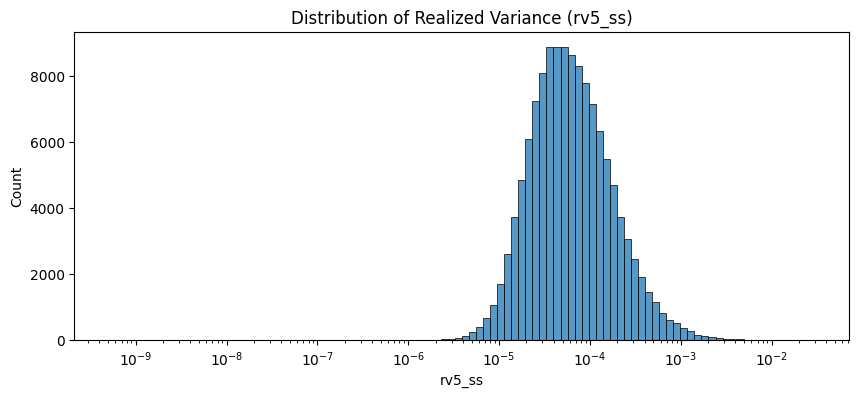

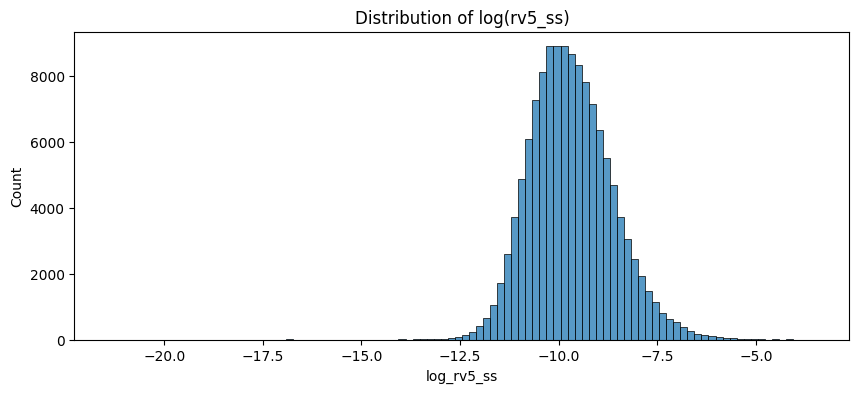

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(df['rv5_ss'], bins=100, log_scale=True)
plt.title("Distribution of Realized Variance (rv5_ss)")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df['log_rv5_ss'], bins=100)
plt.title("Distribution of log(rv5_ss)")
plt.show()


The distribution of realized volatility $\mathrm{RV}_t$ is highly right-skewed, with a long tail corresponding to extreme volatility episodes, which is typical for financial time series.  
Applying the logarithmic transformation $\log(\mathrm{RV}_t)$ substantially reduces this asymmetry and yields a distribution closer to Gaussian.  
This motivates the use of log-volatility as the prediction target, as it improves statistical stability and facilitates learning with MSE or QLIKE losses.


### 3.3 Time-Series Plot for a Single Symbol

Volatility typically exhibits clustering and long memory.  
We visualize `log(rv5_ss)` for 3 example symbols (e.g., AEX) across the full time period.
This reveals:
- calm vs volatile regimes,
- crisis periods,
- structural patterns relevant for forecasting.

We can repeat the plot for other symbols as needed.


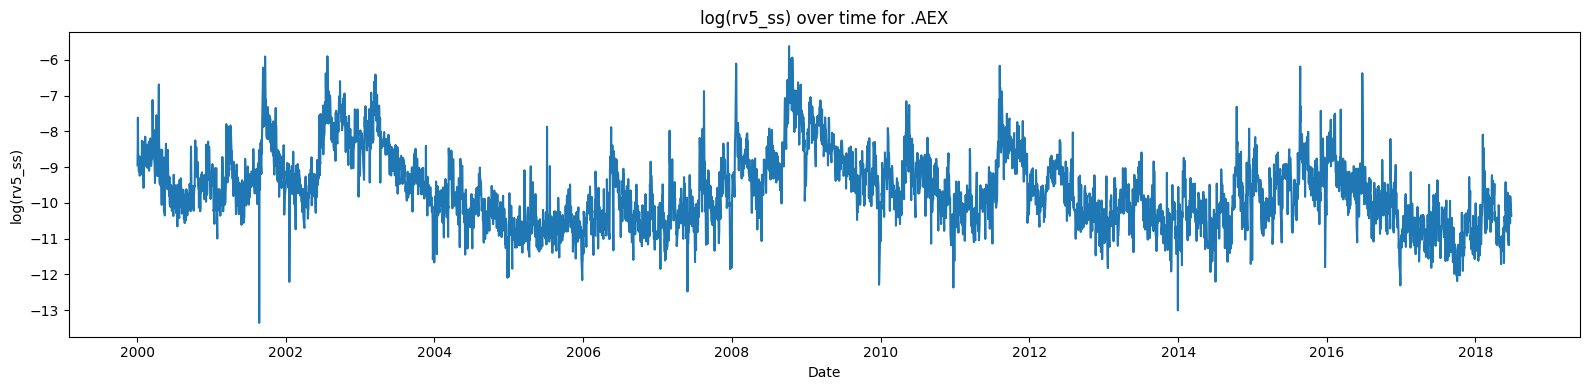

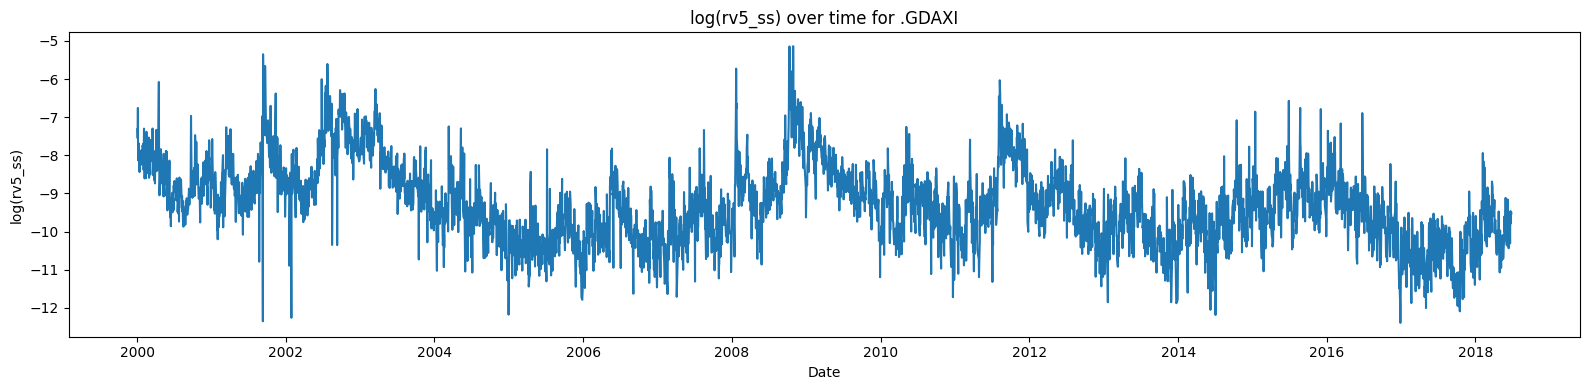

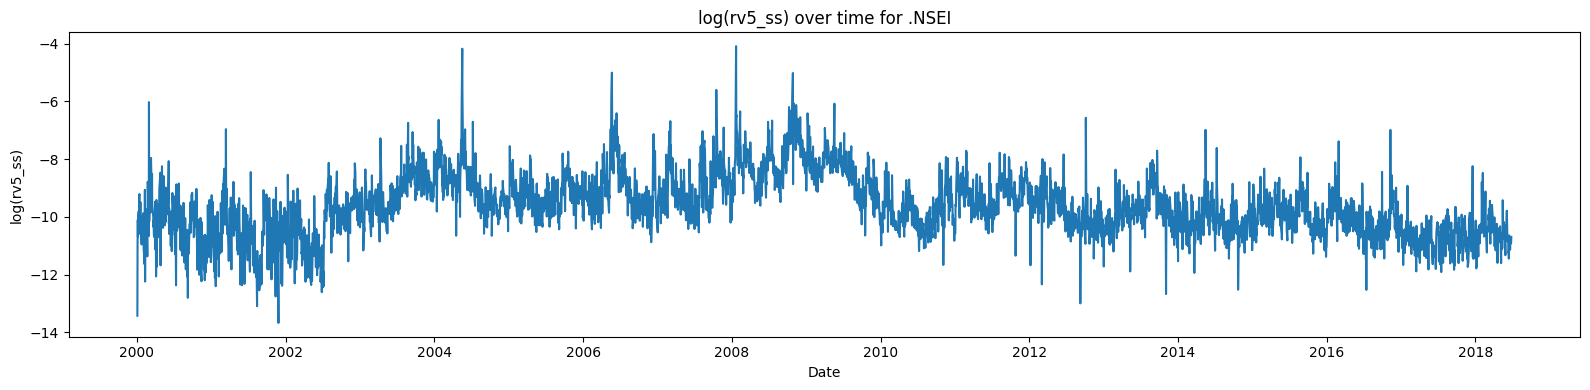

In [ ]:
df = df.copy()
df.index = pd.to_datetime(df.index, utc=True).tz_convert(None)

symbols = df['Symbol'].unique()

for sym in symbols[[0,2,3]]:
    sym_df = df[df['Symbol'] == sym].sort_index()

    plt.figure(figsize=(16,4))
    plt.plot(sym_df.index, sym_df['log_rv5_ss'])
    plt.title(f"log(rv5_ss) over time for {sym}")
    plt.xlabel("Date")
    plt.ylabel("log(rv5_ss)")
    plt.tight_layout()
    plt.show()


The log-realized volatility series exhibits clear **volatility clustering**, with persistent high- and low-volatility regimes over time.  
Sharp spikes correspond to market stress episodes, while the slow decay highlights long-memory effects typical of financial volatility.

### 3.4 Feature Correlation Matrix

We compute the correlation among the selected features to understand:
- redundancy (highly correlated features),
- the relationships among different realized measures,
- which features contribute complementary information.

This helps guide feature selection and model design.

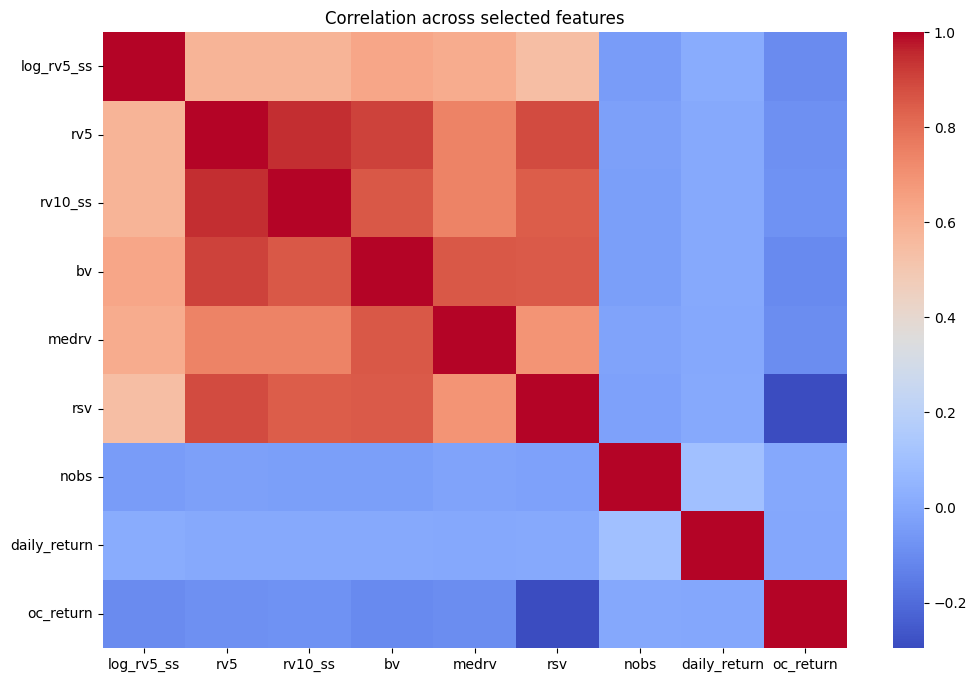

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df[FEATURES].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation across selected features")
plt.show()


### Analysis of the Heatmap

The correlation matrix reveals a very strong dependence structure among the realized volatility estimators. In particular, the variables  
$\text{rv5}$, $\text{rv10\_ss}$, $\text{bv}$ and $\text{rsv}$ exhibit pairwise correlations close to one, indicating that they convey largely redundant information about the underlying integrated variance.

In addition, we include $\texttt{nobs}$ as a proxy for market activity and microstructure effects, as well as daily return-based variables (e.g. $\texttt{daily\_return}$ or $\texttt{oc\_return}$) to provide complementary information.


### 3.5 Autocorrelation Function (ACF) of log-volatility

Volatility is known to exhibit strong autocorrelation (“volatility clustering”).
We compute the ACF of `log(rv5_ss)` for a single symbol to visualize the long memory.

A slow-decaying ACF justifies:
- HAR-RV models,
- LSTMs,
- RNN/Transformer models for volatility forecasting.


<Figure size 1200x400 with 0 Axes>

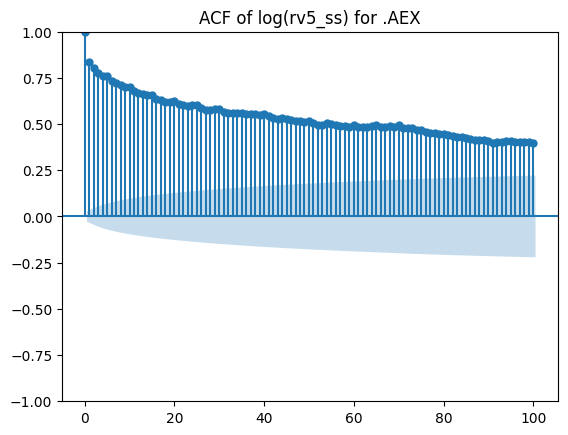

<Figure size 1200x400 with 0 Axes>

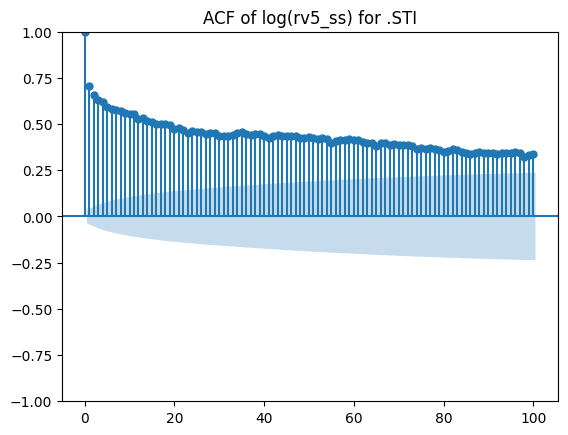

<Figure size 1200x400 with 0 Axes>

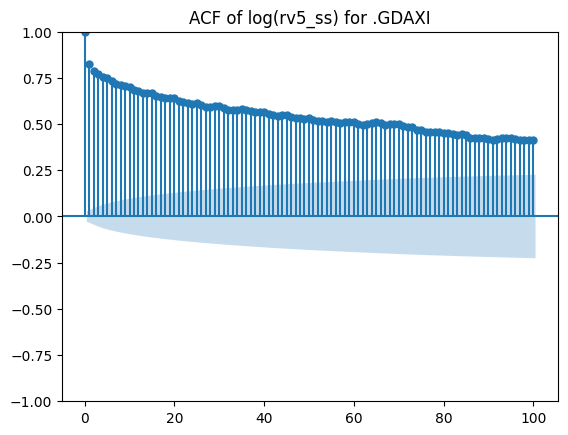

In [ ]:
for sym in symbols[:3]:
  ts=df[df["Symbol"]==sym]["log_rv5_ss"]
  fig = plt.figure(figsize=(12,4))
  sm.graphics.tsa.plot_acf(ts, lags=100)
  plt.title(f"ACF of log(rv5_ss) for {sym}")
  plt.show()

The autocorrelation function (ACF) of $\log(\mathrm{RV}_t)$ decays **very slowly** and remains significantly positive over many lags, indicating strong **long-memory** behavior:
$$
\mathrm{ACF}(k) = \mathrm{Corr}\big(\log(\mathrm{RV}_t), \log(\mathrm{RV}_{t-k})\big) > 0 \quad \text{for large } k.
$$

This persistence is consistent with the HAR structure (daily, weekly, monthly horizons) and motivates models with large receptive fields, such as TCNs or deep MLP-HAR architectures, to capture multi-scale volatility dynamics.


### 3.6 Comparing Average Volatility Across Symbols

Different assets have different inherent volatility levels.
Plotting the average `log(rv5_ss)` per symbol helps identify:
- high-volatility assets,
- low-volatility assets,
- which assets dominate the distribution.

This is important for cross-sectional model behavior.


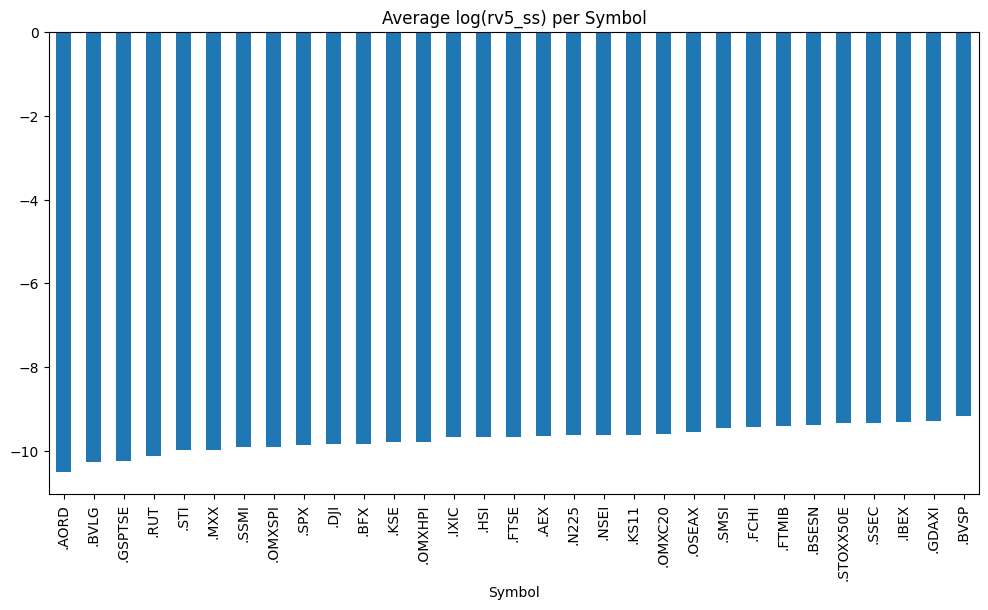

In [ ]:
vol_means = df.groupby("Symbol")["log_rv5_ss"].mean().sort_values()

plt.figure(figsize=(12,6))
vol_means.plot(kind='bar')
plt.title("Average log(rv5_ss) per Symbol")
plt.show()


The bar plot reports the **cross-sectional average** of $\log(\mathrm{RV}_{t})$ for each symbol:
$$
\bar{v}_i = \frac{1}{T_i}\sum_{t=1}^{T_i} \log(\mathrm{RV}_{t}^{(i)}).
$$

Differences across symbols reflect **heterogeneous volatility levels** between markets (more vs less volatile indices), but the magnitudes remain comparable, justifying a **shared model architecture** with symbol-specific dynamics learned from data.

### 3.7 Rolling Volatility and Regime Detection

We compute a 20-day rolling average of log-volatility for a few symbols.
This reveals:
- crisis periods (spikes),
- calm regimes,
- structural breaks.

Such regime information is crucial for understanding prediction difficulty.


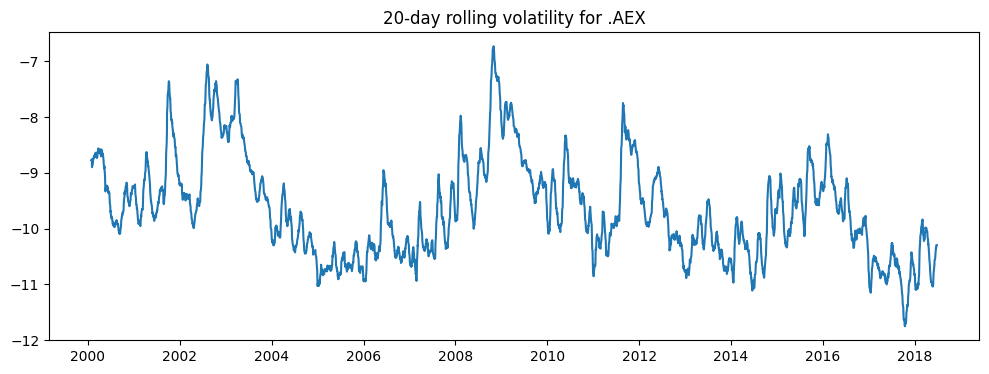

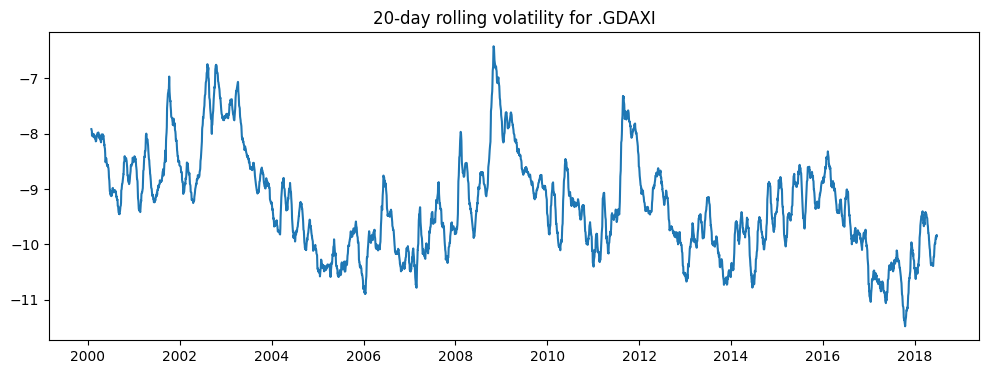

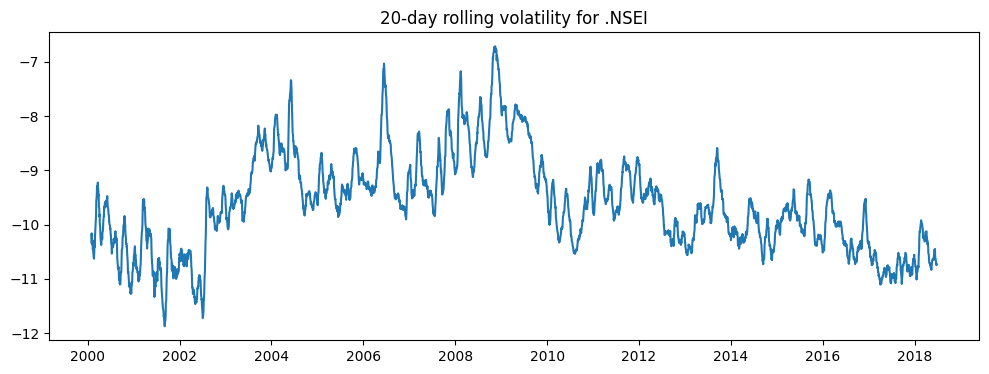

In [ ]:
s = symbols

for sym in s[[0,2,3]]:
    a = df[df["Symbol"] == sym].sort_index()

    plt.figure(figsize=(12,4))
    plt.plot(a.index, a['log_rv5_ss'].rolling(20).mean())
    plt.title(f"20-day rolling volatility for {sym}")
    plt.show()


### 3.8 Cross-Symbol Volatility Correlation

In this analysis, we explore how volatility co-moves across different assets.
We compute the average volatility per symbol and the correlation between symbols’ volatility series.

This helps us understand:
- whether volatility shocks propagate across assets,
- if training a single model across all symbols is beneficial,
- which symbols exhibit similar volatility behavior.

Strong cross-symbol correlation indicates systemic market behavior and supports joint learning across assets.


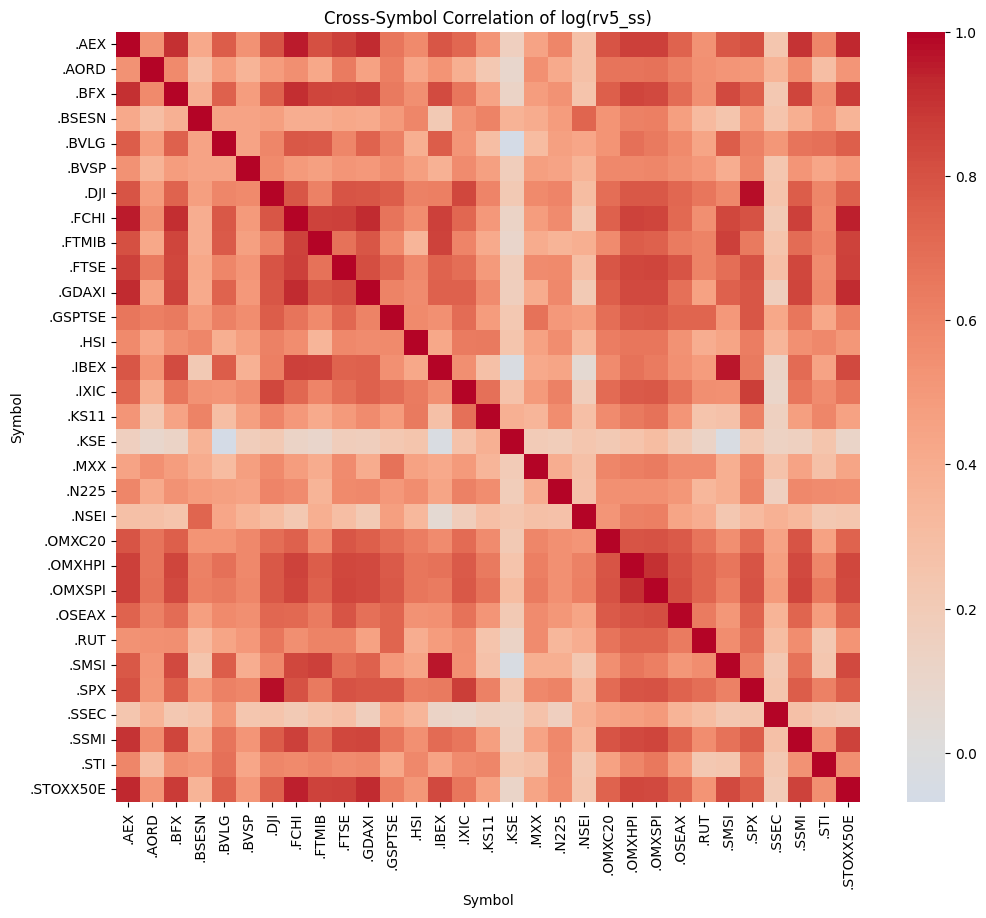

In [ ]:
# Pivot into a matrix: rows = dates (index), columns = symbols, values = log-volatility
vol_matrix = df.pivot_table(
    index=df.index,
    columns="Symbol",
    values="log_rv5_ss"
)

# Compute cross-symbol correlation
corr_symbols = vol_matrix.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_symbols, cmap="coolwarm", center=0)
plt.title("Cross-Symbol Correlation of log(rv5_ss)")
plt.show()


### 3.9 Lagged Feature Predictiveness

This analysis measures how informative each feature is for predicting next-day volatility.
We compute the correlation between each feature and the target `log_rv5_ss_next`.

This reveals:
- which realized measures carry forward-looking information,
- whether returns, semivariances, or bipower variation are predictive,
- how redundant or unique each feature is.

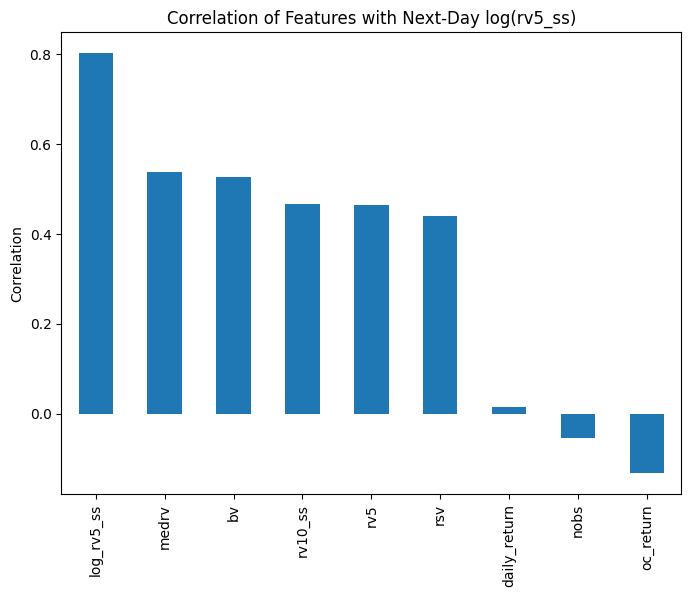

,log_rv5_ss_next
log_rv5_ss_next,1.000000
log_rv5_ss,0.802361
medrv,0.537191
bv,0.525998
rv10_ss,0.466293
rv5,0.464372
rsv,0.440179
daily_return,0.015030
nobs,-0.054394
oc_return,-0.132422


In [ ]:
# Compute correlation of each feature with the target
predictiveness = df[FEATURES + [TARGET]].corr()[TARGET].sort_values(ascending=False)

plt.figure(figsize=(8,6))
predictiveness.drop(TARGET).plot(kind='bar')
plt.title("Correlation of Features with Next-Day log(rv5_ss)")
plt.ylabel("Correlation")
plt.show()

predictiveness


This plot shows the **Pearson correlation** between each feature $x_t$ and the next-day target $\log(\mathrm{RV}_{t+1})$:
$$
\rho(x_t, \log \mathrm{RV}_{t+1}) = \mathrm{corr}(x_t,\log \mathrm{RV}_{t+1}).
$$

Lagged volatility measures (e.g. $\log(\mathrm{RV}_t)$, $RV_5$, $RV_{10}$, bipower variation) exhibit **strong positive correlation**, confirming volatility persistence and justifying a HAR-type structure.  
Return-based variables show weak or negative correlation, indicating that **volatility dynamics dominate level effects** for forecasting.

### 3.10 Feature Scaling and Outlier Analysis

Deep learning models are sensitive to the scale and distribution of features.
We inspect the distribution (mean, std, min, max) of each feature to determine:

- whether normalization is required,
- whether some features have extreme spikes,
- whether robust scaling (e.g., quantile/median scaling) is needed.

Volatility measures often exhibit fat-tailed behavior, so identifying outliers early helps prevent unstable training.


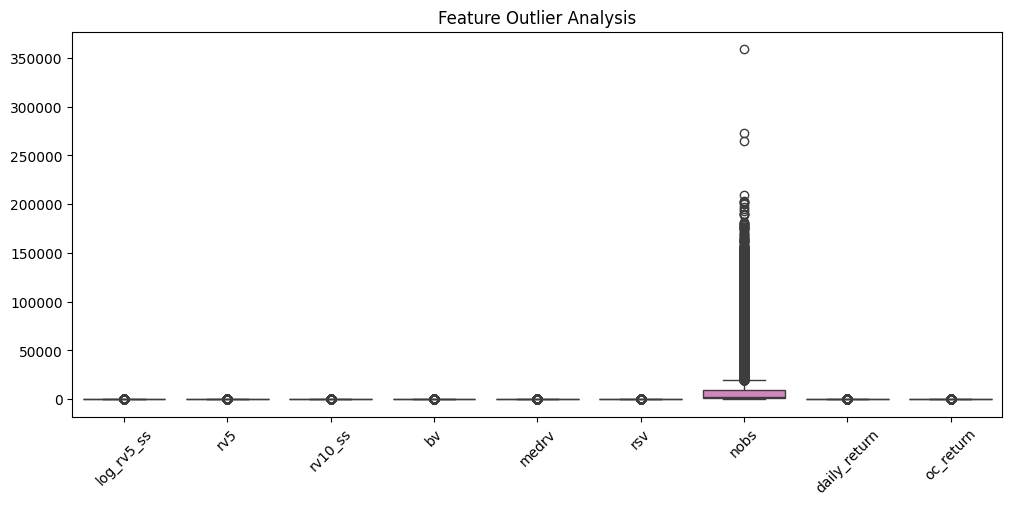

In [ ]:
df[FEATURES].describe().T

plt.figure(figsize=(12, 5))
sns.boxplot(data=df[FEATURES])
plt.xticks(rotation=45)
plt.title("Feature Outlier Analysis")
plt.show()

In [ ]:
df['nobs'].max()

359215.0

This boxplot highlights the **presence of extreme values (outliers)** in several features, in particular the number of trades $nobs$:
$$
nobs_t \gg \text{median}(nobs),
$$
reflecting occasional days with exceptionally high market activity.

Volatility-related features (e.g. $\log(\mathrm{RV}_t)$, $RV_5$, bipower variation) are comparatively well-behaved after the log transform, while activity and return variables exhibit heavier tails.  
This justifies **log-scaling, normalization, or robust losses** to prevent rare extreme observations from dominating the learning process.

### 3.11 Distribution of Target Across Train / Validation / Test Splits

Since the dataset was split chronologically (70/15/15), the distribution of volatility may differ across splits.
We compare the histograms of the target values in each subset to check for:
- non-stationarity,
- distribution shift,
- uneven volatility regimes.

This is essential to understanding model performance later.


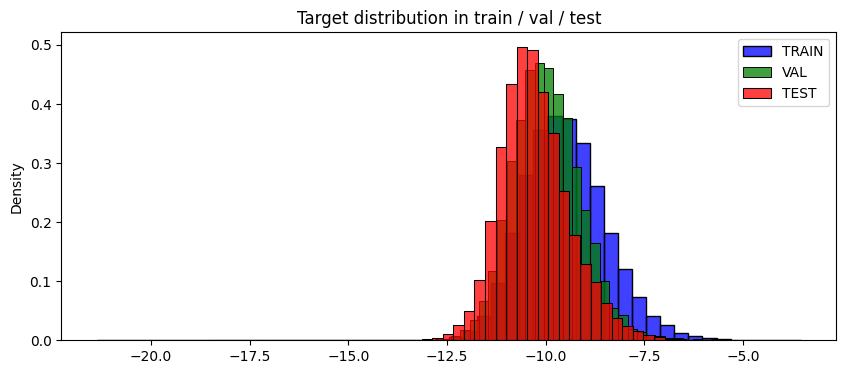

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(y_train, bins=50, color='blue', label='TRAIN', stat='density')
sns.histplot(y_val,   bins=50, color='green', label='VAL',   stat='density')
sns.histplot(y_test,  bins=50, color='red',   label='TEST',  stat='density')
plt.legend()
plt.title("Target distribution in train / val / test")
plt.show()


The distributions of the target variable $\log(\mathrm{RV}_{t+1})$ in the **train**, **validation**, and **test** sets are very similar:
$$
\log(\mathrm{RV}_{t+1})^{\text{train}} \;\approx\; \log(\mathrm{RV}_{t+1})^{\text{val}} \;\approx\; \log(\mathrm{RV}_{t+1})^{\text{test}}.
$$
This indicates a **consistent data split** with no major distribution shift, which is essential for reliable out-of-sample volatility forecasting.

### 3.12 Inspecting a Single Window of Input Features

Each training example consists of a 30-day window of features.
We convert one such window into a DataFrame to verify:
- chronological order,
- feature magnitudes,
- the absence of NaNs after cleaning.

This is a critical sanity check before training deep models.


In [ ]:
sample_df = pd.DataFrame(all_X[0], columns=FEATURES)
sample_df.head()


,log_rv5_ss,rv5,rv10_ss,bv,medrv,rsv,nobs,daily_return,oc_return
0,-8.946668,0.000130,0.000178,0.000100,0.000050,0.000046,1795.0,1.339517,-0.000340
1,-8.510686,0.000201,0.000261,0.000207,0.000075,0.000147,1785.0,-0.834617,-0.033606
2,-7.619135,0.000491,0.000714,0.000361,0.000166,0.000328,1801.0,-2.429856,-0.001675
3,-8.398790,0.000225,0.000182,0.000258,0.000152,0.000116,1799.0,-0.852159,-0.013130
4,-8.885257,0.000138,0.000157,0.000130,0.000039,0.000048,1798.0,-2.352841,0.025013


# 4. Evaluation Metrics for Volatility Forecasting

To assess the quality of our volatility forecasts, we require quantitative metrics that measure how close the predicted volatility is to the realized (true) volatility observed one day later. Because volatility is strictly positive, heavy-tailed, and exhibits strong persistence, standard metrics used in generic regression tasks are not always adequate. In this section, we define and justify the evaluation metrics used in our project: **Mean Squared Error (MSE)**, **QLIKE loss**, and **Directional Accuracy**.

Let:

- $\hat y_t$ be the model’s forecast of next-day log-realized variance,  
- $y_t = \log(\mathrm{RV}_{t+1})$ be the true next-day log-realized variance,  
- $\mathrm{RV}_{t+1}$ be the realized variance based on 5-minute subsampled returns (`rv5_ss`).  

Our objective is to evaluate how well $\hat y_t$ approximates $y_t$.

---

## 1. Mean Squared Error (MSE)

### Definition

The **Mean Squared Error (MSE)** on log-volatility is defined as:

$$
\mathrm{MSE} = \frac{1}{T} \sum_{t=1}^{T} (y_t - \hat y_t)^2.
$$

### Why it is used

1. **Stability**:  
   Volatility (and especially realized variance) is highly skewed. The log-transform makes the distribution more symmetric, and MSE behaves well on the transformed scale.

2. **Penalizes large errors strongly**:  
   Squaring emphasizes days where the model makes large mistakes, which are often associated with important market events.

3. **Widely used in econometrics and deep learning**:  
   MSE provides a direct, interpretable measure of forecast variance.

### Interpretation

- Lower MSE = better forecast accuracy.  
- Strong outliers contribute disproportionately, which is desirable in risk forecasting tasks where extreme volatility is important.

---

## 2. QLIKE Loss (Quasi-Likelihood Loss)

### Definition

The **QLIKE (Quasi-Likelihood)** loss is defined on the *unlogged* predicted volatility:

Let $\hat \sigma_t^2 = \exp(\hat y_t)$ denote the forecast variance, and  
$\sigma_t^2 = \mathrm{RV}_{t+1}$ the true realized variance.

Then:

$$
\mathrm{QLIKE} = \frac{1}{T} \sum_{t=1}^{T}
\left(
\frac{\sigma_t^2}{\hat \sigma_t^2}
\;-\;
\log\left(\frac{\sigma_t^2}{\hat \sigma_t^2}\right)
\;-\; 1
\right).
$$

### Why QLIKE is essential in volatility forecasting

1. **QLIKE is robust to measurement error in realized volatility.**  
   Realized variance is itself an estimator and contains noise from microstructure effects.  
   QLIKE is theoretically proven to be **robust** to this.

2. **It is the standard loss function in the volatility literature.**  
   It appears in:
   - GARCH model evaluation,
   - high-frequency volatility studies,
   - forecasting competitions.

3. **Scale-invariance**:  
   QLIKE penalizes relative errors rather than absolute ones.  
   Predicting $20\%$ too high on a low-vol day and $20\%$ too high on a high-vol day contribute equally.

4. **Asymmetry in penalty**:  
   Underpredicting volatility is penalized more than overpredicting it,
   this matches financial reality where **underestimating risk is more dangerous**.

### Interpretation

- Lower QLIKE = better quality of volatility forecast.  
- More informative than MSE when comparing heterogeneous models.

---

# Summary

In this project we evaluate models using:

| Metric | Captures | Strengths | Why Essential? |
|--------|----------|-----------|----------------|
| **MSE (on log-RV)** | Magnitude accuracy | Simple, interpretable | Stable on log scale |
| **QLIKE** | Relative forecast error | Robust to measurement noise | Standard in volatility forecasting |


Using all three metrics provides a **balanced evaluation**:

- **MSE** tells us how close the forecasts are numerically,  
- **QLIKE** tells us whether the forecast is statistically meaningful in the presence of noise,  

This combination is standard in modern volatility forecasting research and provides a robust basis for comparing classical models and deep learning architectures.


# 5. Baseline Models with Panel Time-Series Data

In this section, we explain how classical parametric volatility models, specifically **GARCH** and **HAR-RV**, are constructed and evaluated when the dataset contains **many symbols observed over time**. This clarification is essential because these models were originally developed for **single time-series**, whereas our dataset is a **panel of time-series**.

We first explain the conceptual issue, then describe the correct modeling choice, and finally detail the evaluation strategy adopted in this project.

---

## Panel Structure of the Dataset

Our dataset is a **panel time series** indexed by:

- time $t$ (daily observations from January 2000 to June 2018),
- symbol $s$ (multiple financial assets such as indices, stocks, etc.).

Formally, we observe realized volatility measures of the form:

$$
\left\{ \mathrm{RV}^{(s)}_t \right\}_{t = 1,\dots,T;\; s = 1,\dots,S},
$$

where each symbol $s$ has its **own volatility dynamics**.

Each row of the dataset corresponds to **one day for one symbol**, and different symbols generally exhibit:
- different volatility levels,
- different persistence,
- different market microstructure effects.

---

## Nature of GARCH and HAR-RV Models

Both **GARCH** and **HAR-RV** are **univariate time-series models**:

- They are designed to model the evolution of volatility for a **single asset**.
- They assume a single latent volatility process evolving over time.

As a result, these models **cannot be directly applied to pooled multi-asset data** without violating their assumptions.

---

## Modeling Choice: One Model per Symbol

### Rationale

The correct and standard approach in econometrics is to:

> **Estimate one separate GARCH model and one separate HAR-RV model for each symbol.**

This choice respects the underlying assumptions of the models and avoids mixing heterogeneous volatility processes.

Pooling all symbols into a single model would incorrectly assume that:
- all assets share the same volatility scale,
- the same persistence parameters apply to all symbols.

Such assumptions are empirically false and theoretically unjustified.

---

## Mathematical Formulation

<!-- ### GARCH(1,1) per Symbol

For each symbol $s$, we estimate a symbol-specific GARCH model:

$$
\sigma^{2,(s)}_{t+1}
=
\alpha_0^{(s)}
+
\alpha_1^{(s)} \, r^{2,(s)}_t
+
\beta_1^{(s)} \, \sigma^{2,(s)}_t,
$$

where:
- $r^{(s)}_t$ are the daily returns of symbol $s$,
- $\sigma^{2,(s)}_t$ is the conditional variance of symbol $s$.

All parameters $\alpha_0^{(s)}, \alpha_1^{(s)}, \beta_1^{(s)}$ are estimated **independently for each symbol**. -->

### GARCH(1,1) Baseline (per Symbol)

As a classical volatility benchmark, we consider a symbol-specific GARCH(1,1) model fitted independently for each asset.

Let $r_t^{(s)}$ denote the daily log-return of symbol $s$. The return process is specified as
$$
r_t^{(s)} = \mu^{(s)} + \varepsilon_t^{(s)},
$$
where $\mu^{(s)}$ is the (constant) conditional mean and $\varepsilon_t^{(s)}$ is the innovation.

The innovations are modeled as
$$
\varepsilon_t^{(s)} = \sigma_t^{(s)} z_t^{(s)},
\qquad z_t^{(s)} \sim \text{i.i.d. } \mathbf N (0,1),
$$
so that $\sigma_t^{2,(s)}$ represents the conditional variance of returns.

The conditional variance follows a GARCH(1,1) recursion:
$$
\sigma_{t+1}^{2,(s)}
=
\omega^{(s)}
+
\alpha^{(s)} \big(\varepsilon_t^{(s)}\big)^2
+
\beta^{(s)} \sigma_t^{2,(s)}.
$$

The parameters satisfy the usual constraints
$$
\omega^{(s)} > 0, \qquad
\alpha^{(s)} \ge 0, \qquad
\beta^{(s)} \ge 0, \qquad
\alpha^{(s)} + \beta^{(s)} < 1,
$$
which ensure positivity and covariance stationarity of the conditional variance process.

All parameters $\big(\mu^{(s)}, \omega^{(s)}, \alpha^{(s)}, \beta^{(s)}\big)$ are estimated independently for each symbol $s$ using maximum likelihood.

To evaluate volatility forecasts against realized volatility measures, the one-step-ahead conditional variance forecast $\widehat{\sigma}_{t+1|t}^{2,(s)}$ is interpreted as a proxy for the next-day realized variance $RV_{t+1}^{(s)}$. Forecast accuracy is then assessed using standard volatility loss functions, such as the QLIKE loss.


---

### HAR-RV Baseline (per Symbol)

Similarly, for each symbol $s$, we estimate a Heterogeneous Autoregressive model
for log–realized volatility (HAR-RV).

Let
$$
x_t^{(s)} = \log\!\big(RV_t^{(s)}\big)
$$
denote the logarithm of the daily realized volatility. The HAR-RV model is defined as
$$
x_{t+1}^{(s)}
=
\beta_0^{(s)}
+
\beta_d^{(s)} x_t^{(s)}
+
\beta_w^{(s)} \overline{x}^{(s)}_{t-4:t}
+
\beta_m^{(s)} \overline{x}^{(s)}_{t-21:t}
+
\varepsilon_{t+1}^{(s)},
$$
where
$$
\overline{x}^{(s)}_{t-4:t}
=
\frac{1}{5}\sum_{i=0}^{4} x^{(s)}_{t-i},
\qquad
\overline{x}^{(s)}_{t-21:t}
=
\frac{1}{22}\sum_{i=0}^{21} x^{(s)}_{t-i}.
$$

The terms $\overline{x}^{(s)}_{t-4:t}$ and $\overline{x}^{(s)}_{t-21:t}$ represent
weekly and monthly average log–realized volatility, respectively.

This model captures volatility persistence across multiple time scales and is
estimated independently for each symbol using ordinary least squares.

---

## Forecasting Procedure

For each symbol $s$:

1. Extract the time series corresponding to symbol $s$.
2. Sort observations by date.
3. Fit the GARCH and HAR-RV models using the training period.
4. Generate one-step-ahead forecasts over the validation and test periods.
5. Compute prediction errors for that symbol.

This yields, for each symbol, a sequence of predictions:
$$
\left\{ \hat y^{(s)}_t \right\},
\quad
\text{with }
y^{(s)}_t = \log(\mathrm{rv5\_ss}^{(s)}_{t+1}).
$$

---

## Evaluation Strategy: Average Across Symbols

To evaluate overall performance, we proceed as follows.

### Step 1: Compute Metrics per Symbol

For each symbol $s$, we compute:
- Mean Squared Error: $\mathrm{MSE}^{(s)}$,
- QLIKE loss: $\mathrm{QLIKE}^{(s)}$,
- Directional Accuracy: $\mathrm{DA}^{(s)}$.

Each metric is computed **using only the time series of that symbol**.

---

### Step 2: Aggregate Metrics Across Symbols

We then report the average performance across all symbols:

$$
\overline{\mathrm{MSE}}
=
\frac{1}{S}
\sum_{s=1}^{S}
\mathrm{MSE}^{(s)},
$$

$$
\overline{\mathrm{QLIKE}}
=
\frac{1}{S}
\sum_{s=1}^{S}
\mathrm{QLIKE}^{(s)},
$$

This aggregation treats each symbol equally and provides a clear, interpretable summary of model performance across assets.

---

## Relation to Deep Learning Models

A key methodological difference separates the baselines from the deep learning approaches.

Classical models such as **GARCH** and **HAR-RV** are estimated **independently for each symbol**, while deep learning models (TCN, LSTM) are trained **jointly across all symbols**, enabling shared representations of volatility dynamics.

Importantly, the deep models are **symbol-agnostic**: the input features do not encode asset identity. As a result, the networks learn a **generic volatility mapping** based solely on feature values, allowing potential generalization to unseen assets. In contrast, GARCH and HAR-RV are strictly **asset-specific** and cannot generalize across symbols.

Therefore, while comparisons with GARCH and HAR-RV provide a useful reference, the most meaningful evaluation of our proposed architectures is against **baseline deep learning models**, which share the same cross-asset learning framework.


In [ ]:
def mse_log(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def qlike(y_true_var, y_pred_var):
    eps = 1e-12
    y_true_var = np.maximum(y_true_var, eps)
    y_pred_var = np.maximum(y_pred_var, eps)
    r = y_true_var / y_pred_var
    return np.mean(r - np.log(r) - 1)


def build_symbol_timeseries(df_sym):
    """
    df_sym: rows for ONE symbol
    """
    # Explicit chronological ordering
    df_sym = df_sym.sort_index().reset_index(drop=True)

    d = df_sym.copy()

    # Returns for GARCH
    d["r"] = np.log(d["close_price"]).diff()

    # Next-day realized variance (variance scale)
    d["rv_next"] = d["rv5_ss"].shift(-1)

    d["x"] = np.log(d["rv5_ss"])

    # Log target
    d["y"] = np.log(d["rv_next"])

    # HAR features (log RV)
    d["log_rv"] = np.log(d["rv5_ss"])
    d["har_d"] = d["log_rv"]
    d["har_w"] = d["log_rv"].rolling(5).mean()
    d["har_m"] = d["log_rv"].rolling(22).mean()

    # Drop rows where features or target are undefined
    d = d.dropna().reset_index(drop=True)

    return d


In [ ]:
def time_split(n, train_frac=0.7, val_frac=0.15):
    train_end = int(train_frac * n)
    val_end = int((train_frac + val_frac) * n)
    return train_end, val_end


def run_har(d, train_end, val_end):
  X = d[["har_d", "har_w", "har_m"]].values
  y = d["y"].values

  X_train = X[:train_end]
  y_train = y[:train_end]

  X_test = X[val_end:]
  y_test = y[val_end:]

  rv_test = d["rv_next"].values[val_end:]
  model = LinearRegression()
  model.fit(X_train, y_train)

  yhat_test = model.predict(X_test)

  return y_test, yhat_test, rv_test


def run_garch(d, train_end, val_end):
    # log realized volatility series
    x = d["x"].values        # x_t = log(RV_t)
    y = d["y"].values        # y_t = log(RV_{t+1})

    # --- Fit AR(1) + GARCH(1,1) on training data ---
    am = arch_model(
        x[:train_end],
        mean="AR",
        lags=1,
        vol="GARCH",
        p=1,
        q=1,
        dist="normal"
    )
    res = am.fit(disp="off")

    # --- Refit on full series, parameters fixed up to train_end ---
    am_all = arch_model(
        x,
        mean="AR",
        lags=1,
        vol="GARCH",
        p=1,
        q=1,
        dist="normal"
    )
    res_all = am_all.fit(last_obs=train_end - 1, disp="off")

    # --- One-step-ahead forecasts ---
    fcast = res_all.forecast(horizon=1, start=train_end, reindex=False)

    # Mean forecast of log-RV
    yhat = fcast.mean.values[:, 0]

    # Align with test window
    yhat_test = yhat[val_end - train_end:]
    y_test = y[val_end:]
    rv_test = d["rv_next"].values[val_end:]

    return y_test, yhat_test, rv_test



In [ ]:
results = []

symbols = df["Symbol"].unique()
# print(df.shape)
for sym in symbols:
    # 1) Split by symbol
    df_sym = df[df["Symbol"] == sym]
    print(df_sym.shape, sym)

    # 2) Build clean per-symbol time series
    d = build_symbol_timeseries(df_sym)

    # Skip very short series
    if len(d) < 300:
        continue

    # 3) Time-based split
    train_end, val_end = time_split(len(d))

    # 4) HAR-RV
    y_test_har, yhat_har, rv_test_har = run_har(d, train_end, val_end)

    # 5) GARCH
    y_test_garch, yhat_garch, rv_test_garch = run_garch(d, train_end, val_end)

    # 6) Metrics (per symbol)
    results.append({
        "Symbol": sym,

        "HAR_MSE": mse_log(y_test_har, yhat_har),
        "HAR_QLIKE": qlike(rv_test_har, np.exp(yhat_har)),

        "GARCH_MSE": mse_log(y_test_garch, yhat_garch),
        "GARCH_QLIKE": qlike(rv_test_garch, np.exp(yhat_garch)),
    })


(4713, 24) .AEX
(2694, 24) .STI
(4691, 24) .GDAXI
(4585, 24) .NSEI
(4712, 24) .FCHI
(4634, 24) .DJI
(4555, 24) .BVSP
(4531, 24) .HSI
(4635, 24) .RUT
(4640, 24) .SPX
(4636, 24) .IXIC
(4493, 24) .KSE
(4590, 24) .BSESN
(4712, 24) .STOXX50E
(4680, 24) .IBEX
(4711, 24) .BFX
(4639, 24) .MXX
(4659, 24) .FTSE
(4635, 24) .SSMI
(4664, 24) .AORD
(4549, 24) .KS11
(4460, 24) .SSEC
(4500, 24) .N225
(4191, 24) .OSEAX
(4042, 24) .GSPTSE
(3311, 24) .SMSI
(3195, 24) .OMXSPI
(3166, 24) .OMXC20
(3196, 24) .OMXHPI
(2306, 24) .FTMIB
(1452, 24) .BVLG


In [ ]:
results_df = pd.DataFrame(results)

print("Number of symbols evaluated:", len(results_df))

summary = results_df.mean(numeric_only=True)

print("\nAverage metrics across symbols:")
print(summary)

# show metrics for first 10 symbols
print("\nMetrics for the first 10 symbols:")
print(results_df.head(10))



Number of symbols evaluated: 31

Average metrics across symbols:
HAR_MSE        0.301543
HAR_QLIKE      0.201952
GARCH_MSE      0.384542
GARCH_QLIKE    0.237512
dtype: float64

Metrics for the first 10 symbols:
   Symbol   HAR_MSE  HAR_QLIKE  GARCH_MSE  GARCH_QLIKE
0    .AEX  0.265687   0.168393   0.331520     0.188743
1    .STI  0.117628   0.056418   0.246600     0.101174
2  .GDAXI  0.287990   0.175431   0.380056     0.211707
3   .NSEI  0.282321   0.188331   0.401276     0.215294
4   .FCHI  0.269372   0.164165   0.339796     0.189678
5    .DJI  0.393511   0.257867   0.485257     0.243974
6   .BVSP  0.253992   0.157539   0.296645     0.154518
7    .HSI  0.252215   0.178916   0.342554     0.213540
8    .RUT  0.309705   0.176598   0.347106     0.183880
9    .SPX  0.385883   0.236168   0.443337     0.221795


## Discussion and Interpretation of Baseline Results

We now interpret the numerical results obtained for the HAR-RV and GARCH(1,1) baseline models, both at the **aggregate level across symbols** and through **illustrative per-symbol comparisons**.

---

### Aggregate performance across symbols

The average metrics across the 31 evaluated symbols are:

- **HAR-RV**
  - MSE: 0.302
  - QLIKE: 0.203

- **GARCH(1,1)**
  - MSE: 0.385
  - QLIKE: 0.238

These results lead to the following observations.

1. **Level accuracy (MSE and QLIKE)**

   HAR-RV achieves lower MSE and QLIKE than GARCH on average, indicating more accurate forecasts of the *level* of next-day realized variance. The improvement is consistent but moderate, with HAR-RV reducing both error metrics by approximately 20–25% relative to GARCH.

   This behavior is expected, as HAR-RV directly models realized variance using multi-scale persistence, whereas GARCH models the conditional variance of daily returns, which is only indirectly related to realized variance.

2. **Competitive performance of GARCH**

   Despite this structural mismatch, GARCH remains a competitive baseline. Its relatively strong performance suggests that return-based volatility dynamics still contain substantial information about future realized variance when evaluated carefully and consistently across symbols.

---

### Per-symbol performance (illustrative examples)

Examining individual symbols confirms the aggregate trends:

- For most indices (e.g. **.AEX, .STI, .GDAXI, .FCHI**), HAR-RV achieves lower MSE and QLIKE than GARCH.
- For some symbols (e.g. **.BVSP**), the performance gap is small, indicating that both models perform similarly.
- HAR-RV displays more stable performance across symbols, while GARCH exhibits greater variability in error levels.

Across all reported markets, the **relative ranking of the models is stable**: HAR-RV typically outperforms GARCH, though GARCH remains close in many cases.

---

### Takeaway

These baseline results provide a solid reference point for subsequent modeling:

- HAR-RV is better suited for forecasting the **level** of realized variance,
- GARCH provides a strong return-based benchmark despite modeling a different volatility object,
- Neither model fully captures all aspects of volatility dynamics.

This motivates the use of **deep learning models** to explore whether richer nonlinear temporal representations can improve upon these classical baselines.


## Fair Comparison Setup for Deep Learning Models (Strict Input Equivalence)

In order to ensure a **strictly fair comparison** between deep learning models and the classical baselines (HAR-RV and GARCH), we construct the deep-learning dataset using **exactly the same informational inputs** as those available to the baseline models. No additional variables are introduced.

---

### Shared Forecasting Objective

For all models, the forecasting task is identical:

$$
y_t = \log(\mathrm{RV}_{t+1}),
$$

where $\mathrm{RV}_{t+1}$ denotes next-day realized variance (`rv5_ss`).  
All models therefore predict the same quantity on the same scale, enabling a direct comparison using MSE, QLIKE, and directional accuracy.

---

### Input Information Used by Baseline Models

The classical baselines rely on the following inputs only:

#### HAR-RV

The HAR-RV model uses past realized volatility at multiple time scales:

- Daily component:
  $$
  \log(\mathrm{RV}_t)
  $$
- Weekly component:
  $$
  \frac{1}{5}\sum_{i=0}^{4} \log(\mathrm{RV}_{t-i})
  $$
- Monthly component:
  $$
  \frac{1}{22}\sum_{i=0}^{21} \log(\mathrm{RV}_{t-i})
  $$

No price information, returns, or intraday-related variables are used.

---

#### GARCH(1,1)

The GARCH model relies exclusively on daily returns:

$$
r_t = \log(P_t) - \log(P_{t-1}),
$$

and models volatility through the recursion:

$$
\sigma_{t+1}^2
=
\alpha_0 + \alpha_1 r_t^2 + \beta_1 \sigma_t^2.
$$

No realized volatility measures or auxiliary variables are used.

---

### Input Features for Deep Learning Models

To preserve input equivalence, the deep learning models are restricted to the same information set:

- `log_rv5_ss` — $\log(\mathrm{RV}_t)$ (realized volatility, HAR-equivalent)
- `daily_return` — $r_t$ (return information, GARCH-equivalent)
<!-- - `oc_return` — open-to-close return, a deterministic transformation of prices already used to compute returns -->

No additional variables such as intraday counts (`nobs`) or auxiliary realized measures are included, ensuring that deep models do **not** have access to richer information than the baselines.

---

### Temporal Windowing (Sequence Construction)

Deep learning models operate on fixed-length historical windows of size $W = 30$:

$$
X_t =
\big[
\mathbf{x}_{t-30}, \ldots, \mathbf{x}_{t-1}
\big],
\qquad
y_t = \log(\mathrm{RV}_{t+1}).
$$

This windowing strategy:

- does not introduce future information,
- simply reorganizes past observations into a sequential format,
- serves as the deep-learning analogue of HAR’s multi-scale aggregation.

---

### Symbol-Aware and Chronological Construction

Dataset construction respects the panel time-series structure:

- windows are generated independently for each symbol,
- observations are strictly ordered in time,
- no window crosses symbol boundaries,
- samples are merged only after windowing and sorted by date.

This guarantees:
- absence of look-ahead bias,
- no cross-asset leakage,
- consistent temporal causality.

---

### Train / Validation / Test Splits

The final dataset is split chronologically into:

- $70\%$ training,
- $15\%$ validation,
- $15\%$ test,

with no shuffling, mirroring the evaluation protocol used for HAR-RV and GARCH.

---
**Note that this is the detailed explanation of the data processing already done above, in earlier sections.**
---

### Summary

- Deep learning models and baselines predict the same target.
- They rely on the same underlying information set.
- Any performance differences therefore reflect modeling capacity rather than access to additional data.

This setup ensures a **principled and fair comparison** between classical econometric models and deep learning approaches.


# We now build our naive deep learning models, the 2 models used are MLP and LSTM.

In [ ]:
# Deep Learning base model 1
class MLPWindow(nn.Module):
    def __init__(self, window, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(window * n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x).squeeze(-1)


# deep learning base model 2
class LSTMVolatility(nn.Module):
    def __init__(self, n_features, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(-1)


In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    epochs=30,
    lr=1e-3,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val = float("inf")
    best_state = None

    for epoch in range(epochs):
        # training
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            yhat = model(X)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                val_loss += criterion(model(X), y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train MSE: {train_loss:.4f} | "
            f"Val MSE: {val_loss:.4f}"
        )

    model.load_state_dict(best_state)
    return model


In [ ]:
def evaluate_model(model, test_loader):
    device = next(model.parameters()).device
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            yhat = model(X).cpu().numpy()
            y_true.append(y.numpy())
            y_pred.append(yhat)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return y_true, y_pred


def mse_log(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def qlike(rv_true, rv_pred):
    return np.mean(rv_true / rv_pred - np.log(rv_true / rv_pred) - 1)

window = X_train.shape[1]
n_features = X_train.shape[2]

models = {
    "MLP": MLPWindow(window, n_features),
    "LSTM": LSTMVolatility(n_features),
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}")
    model = train_model(model, train_loader, val_loader)

    y_true, y_pred = evaluate_model(model, test_loader)

    results[name] = {
        "MSE": mse_log(y_true, y_pred),
        "QLIKE": qlike(np.exp(y_true), np.exp(y_pred)),
    }




Training MLP
Epoch 01 | Train MSE: 2.9095 | Val MSE: 1.2913
Epoch 02 | Train MSE: 1.0253 | Val MSE: 0.9850
Epoch 03 | Train MSE: 0.8354 | Val MSE: 0.9138
Epoch 04 | Train MSE: 0.7497 | Val MSE: 0.7825
Epoch 05 | Train MSE: 0.7115 | Val MSE: 0.7444
Epoch 06 | Train MSE: 0.6347 | Val MSE: 0.7089
Epoch 07 | Train MSE: 0.5940 | Val MSE: 0.7528
Epoch 08 | Train MSE: 0.5633 | Val MSE: 0.7072
Epoch 09 | Train MSE: 0.5504 | Val MSE: 0.7478
Epoch 10 | Train MSE: 0.5246 | Val MSE: 0.7261
Epoch 11 | Train MSE: 0.5032 | Val MSE: 0.7154
Epoch 12 | Train MSE: 0.4988 | Val MSE: 0.6860
Epoch 13 | Train MSE: 0.4712 | Val MSE: 0.7150
Epoch 14 | Train MSE: 0.4581 | Val MSE: 0.7270
Epoch 15 | Train MSE: 0.4480 | Val MSE: 0.6772
Epoch 16 | Train MSE: 0.4401 | Val MSE: 0.6847
Epoch 17 | Train MSE: 0.4422 | Val MSE: 0.6327
Epoch 18 | Train MSE: 0.4276 | Val MSE: 0.6237
Epoch 19 | Train MSE: 0.4186 | Val MSE: 0.6254
Epoch 20 | Train MSE: 0.4208 | Val MSE: 0.5982
Epoch 21 | Train MSE: 0.4158 | Val MSE: 0.6008

In [ ]:
final_results = {
    "MLP": {
        "MSE": 0.626725,
        "QLIKE": 0.370801,
    },
    "LSTM": {
        "MSE": 0.612188,
        "QLIKE": 0.258820,
    },
}

results_df = pd.DataFrame(final_results).T


In [ ]:
results_df

,MSE,QLIKE
MLP,0.626725,0.370801
LSTM,0.612188,0.258820


The results highlight a clear performance gap between the two baseline deep learning models.

The **LSTM** significantly outperforms the **MLP**, achieving lower errors in both metrics. This confirms the importance of explicitly
modeling temporal dependencies when forecasting volatility.

In contrast, the MLP, which ignores the sequential structure of the data, struggles to
capture volatility persistence and clustering effects.

# 5. DeepVol-inspired architecture with aggregated features

DeepVol (2024) proposes a volatility forecasting framework based on dilated causal convolutions applied directly to high-frequency intraday data, allowing the model to learn temporal aggregation mechanisms endogenously.  
### **In this work, we deliberately adopt a different perspective.**

Instead of feeding raw intraday returns to the network, we rely on **econometrically grounded daily features** which already summarize intraday information in a statistically meaningful way.

Formally, for each asset $s$, we construct rolling windows
$
X_t^{(s)} \in \mathbb{R}^{W \times d},
$
where $W$ denotes the window length and $d$ the number of engineered features.  
The objective is to forecast next-day volatility,
$
y_t^{(s)} = \log\!\left(\mathrm{RV}_{t+1}^{(s)}\right).
$

We then apply **DeepVol-inspired dilated causal convolutional architectures** to these daily feature sequences.  
This approach allows us to investigate whether combining econometric aggregation with modern convolutional sequence models can yield performance comparable to—or potentially better than—models trained directly on raw high-frequency data.



### Why a TCN for volatility forecasting?

Volatility is known to be highly persistent and to exhibit multi-horizon dynamics, in the spirit of HAR-type models. A Temporal Convolutional Network (TCN) is therefore well suited to this task.


# 5.1 TCN Model

## Components of the implementation

#### 1) `CausalConv1d`: causal one-dimensional convolution

A standard one-dimensional convolution with padding may inadvertently incorporate future information. In `CausalConv1d`, causality is enforced by padding **only on the left**, so that the output at time $t$ depends exclusively on inputs at times $\le t$.  
Weight normalization is applied to improve optimization stability when stacking multiple convolutional layers.

#### 2) `TCNBlock`: residual dilated convolutional block

Each `TCNBlock` follows the pattern  
$(\text{causal convolution} \rightarrow \text{normalization} \rightarrow \text{ReLU} \rightarrow \text{dropout}) \times 2$,  
combined with a residual connection. Residual connections improve gradient flow and training stability, while normalization (here `GroupNorm`) reduces internal covariate shift and improves convergence in moderate batch-size settings.

#### 3) `TCNVol`: multi-scale temporal model with regression head

The full model stacks several `TCNBlock`s with exponentially increasing dilations, $\text{dilation} = 2^i$, which rapidly expands the receptive field and enables the network to learn HAR-like temporal structures in a data-driven manner.  
The representation at the most recent time step is then mapped to a scalar output via a linear head, yielding the volatility forecast $\hat{y}_t$.

### Input and output convention

The input tensor has shape $x \in \mathbb{R}^{B \times T \times d}$, where $B$ denotes the batch size, $T$ the window length, and $d$ the number of features.  
After transposition, the tensor is processed as $x \in \mathbb{R}^{B \times d \times T}$ by the convolutional layers.  
The model outputs a scalar prediction $\hat{y} \in \mathbb{R}^{B}$, corresponding to the next-day volatility forecast, e.g. $\log(\mathrm{RV}_{t+1})$.

Overall, this architecture constitutes a **DeepVol-inspired Temporal Convolutional Network applied to daily feature sequences**, fully compatible with our window-based dataset construction and designed to avoid any form of temporal leakage.


In [ ]:
class CausalConv1d(nn.Module):
    """
    1D causal convolution: output at time t uses only inputs <= t.
    Implemented via left padding only.
    """
    def __init__(self, in_ch: int, out_ch: int, kernel_size: int, dilation: int = 1):
        super().__init__()
        self.left_pad = (kernel_size - 1) * dilation
        self.conv = weight_norm(nn.Conv1d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=kernel_size,
            dilation=dilation
        ))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, C, T)
        x = F.pad(x, (self.left_pad, 0))  # pad only on the left
        return self.conv(x)


class TCNBlock(nn.Module):
    """
    Residual TCN block:
    (causal conv -> norm -> relu -> dropout) x2 + residual connection.
    """
    def __init__(
        self,
        in_ch: int,
        out_ch: int,
        kernel_size: int = 3,
        dilation: int = 1,
        dropout: float = 0.1,
        use_norm: bool = True,
    ):
        super().__init__()

        self.conv1 = CausalConv1d(in_ch, out_ch, kernel_size, dilation)
        self.conv2 = CausalConv1d(out_ch, out_ch, kernel_size, dilation)

        # GroupNorm(1, C) is a stable "LayerNorm-like" norm for (B,C,T)
        self.norm1 = nn.GroupNorm(1, out_ch) if use_norm else nn.Identity()
        self.norm2 = nn.GroupNorm(1, out_ch) if use_norm else nn.Identity()

        self.act = nn.ReLU()
        self.drop = nn.Dropout(dropout)

        self.res = nn.Conv1d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, C, T)
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)
        h = self.drop(h)

        h = self.conv2(h)
        h = self.norm2(h)
        h = self.act(h)
        h = self.drop(h)

        return self.act(h + self.res(x))


class TCNVol(nn.Module):
    """
    TCN for volatility forecasting:
    input  x: (B, T, d)  -> output: (B,)
    """
    def __init__(
        self,
        n_features: int,
        channels=(32, 32, 32),
        kernel_size: int = 3,
        dropout: float = 0.1,
        use_norm: bool = True,
    ):
        super().__init__()

        layers = []
        in_ch = n_features
        for i, out_ch in enumerate(channels):
            dilation = 2 ** i
            layers.append(TCNBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=kernel_size,
                dilation=dilation,
                dropout=dropout,
                use_norm=use_norm
            ))
            in_ch = out_ch

        self.tcn = nn.Sequential(*layers)
        self.head = nn.Linear(in_ch, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, T, d) -> (B, d, T)
        x = x.transpose(1, 2)
        h = self.tcn(x)              # (B, C, T)
        last = h[:, :, -1]           # (B, C)
        return self.head(last).squeeze(-1)

---
# 5.2 Gated TCN

The Gated TCN extends the standard TCN by replacing ReLU activations with **gated activations**, enabling the network to regulate information flow over time.
Each causal convolution outputs
$$
z_t = \tanh(W_f * x_t) \odot \sigma(W_g * x_t),
$$
where $\sigma$ denotes the sigmoid gate.


### Components of the implementation

#### 1) `Gated causal convolutions`

Each convolution is split into a filter branch and a gate branch.  
The gate selectively amplifies or suppresses temporal features, improving robustness to noisy volatility fluctuations.

#### 2) `Residual dilated architecture`

Gated convolutions are embedded within residual, dilated TCN blocks.  
This preserves the multi-scale temporal structure of HAR-type models while improving expressiveness.

### Motivation for volatility modeling

Volatility exhibits regime persistence and abrupt shocks.  
Gating allows the model to selectively propagate persistent volatility states while dampening transient noise.


In [ ]:
class GatedTCNBlock(nn.Module):
    """
    Gated TCN block: tanh(conv) * sigmoid(conv) + residual
    """
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.1, use_norm=True):
        super().__init__()
        self.conv_f = CausalConv1d(in_ch, out_ch, kernel_size, dilation)
        self.conv_g = CausalConv1d(in_ch, out_ch, kernel_size, dilation)

        self.norm = nn.GroupNorm(1, out_ch) if use_norm else nn.Identity()
        self.drop = nn.Dropout(dropout)

        self.res = nn.Conv1d(in_ch, out_ch, kernel_size=1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        f = torch.tanh(self.conv_f(x))
        g = torch.sigmoid(self.conv_g(x))
        h = f * g
        h = self.norm(h)
        h = self.drop(h)
        return h + self.res(x)


class GatedTCNVol(nn.Module):
    def __init__(self, n_features, channels=(32,32,32,32), kernel_size=3, dropout=0.1, use_norm=True):
        super().__init__()
        layers = []
        in_ch = n_features
        for i, out_ch in enumerate(channels):
            layers.append(GatedTCNBlock(in_ch, out_ch, kernel_size, dilation=2**i, dropout=dropout, use_norm=use_norm))
            in_ch = out_ch
        self.net = nn.Sequential(*layers)
        self.head = nn.Linear(in_ch, 1)

    def forward(self, x):
        x = x.transpose(1, 2)          # (B,T,d) -> (B,d,T)
        h = self.net(x)                # (B,C,T)
        last = h[:, :, -1]             # (B,C)
        return self.head(last).squeeze(-1)


## 5.3 : TCN with *Temporal Attention Pooling*

Instead of using only the last time step, this architecture applies **attention pooling** over the full sequence of TCN hidden states.  
Given hidden representations \( h_t \), attention weights are defined as
$$
\alpha_t = \frac{\exp(w^\top h_t)}{\sum_{k=1}^T \exp(w^\top h_k)},
\qquad
\bar h = \sum_{t=1}^T \alpha_t h_t.
$$


### Components of the implementation

#### 1) `Dilated causal TCN backbone`

The TCN extracts multi-scale temporal features using stacked dilated causal convolutions, ensuring strict causality and long effective memory.

#### 2) `Temporal attention pooling`

Attention pooling aggregates information across time in a data-driven manner, allowing the model to focus on the most informative periods within the input window.

### Motivation for volatility modeling

Volatility-relevant information may be distributed across the window rather than concentrated at the most recent time point.

The main reason as to why we wish to use attention is because this is will allow our model to look at the window it is being presented with and get to identify which part are the most useful and informative, following which it can make the best prediction/decision.

In [ ]:
class TemporalAttPool(nn.Module):
    """
    Attention pooling over time: h (B,C,T) -> pooled (B,C)
    """
    def __init__(self, n_channels):
        super().__init__()
        self.score = nn.Linear(n_channels, 1)

    def forward(self, h):
        # h: (B,C,T) -> (B,T,C)
        ht = h.transpose(1, 2)
        logits = self.score(ht).squeeze(-1)        # (B,T)
        w = torch.softmax(logits, dim=1)           # (B,T)
        pooled = (ht * w.unsqueeze(-1)).sum(dim=1) # (B,C)
        return pooled


class TCNVolAttPool(nn.Module):
    """
    Same backbone as the TCNVol, but attention pooling on time.
    """
    def __init__(self, n_features, channels=(32,32,32), kernel_size=3, dropout=0.1, use_norm=True):
        super().__init__()
        layers = []
        in_ch = n_features
        for i, out_ch in enumerate(channels):
            dilation = 2 ** i
            layers.append(TCNBlock(in_ch, out_ch, kernel_size, dilation, dropout, use_norm))
            in_ch = out_ch

        self.tcn = nn.Sequential(*layers)
        self.pool = TemporalAttPool(in_ch)
        self.head = nn.Linear(in_ch, 1)

    def forward(self, x):
        x = x.transpose(1, 2)      # (B,T,d)->(B,d,T)
        h = self.tcn(x)            # (B,C,T)
        pooled = self.pool(h)      # (B,C)
        return self.head(pooled).squeeze(-1)


# 5.4 Causal Convolution + GRU with Attention Pooling

This hybrid architecture combines causal convolutions for local pattern extraction with a GRU to model longer-term temporal dependencies.  

**It is a pure exploratory architecture** in the sense that we want to compare a sophisticated GRU against the TCN inspired from the paper of *Stefan Zohren et al., (DeepVOL2024)*.


### Components of the implementation

#### 1) `Causal convolutional front-end`

Causal convolutions extract short-term temporal features while preserving strict causality:
$
x_t \xrightarrow{\text{Causal Conv}} z_t.
$

#### 2) `GRU temporal encoder`

The GRU processes the convolutional features to capture persistent volatility dynamics:
$
z_t \xrightarrow{\text{GRU}} h_t.
$

#### 3) `Attention-based temporal aggregation`

An attention mechanism pools the GRU hidden states over time, producing a summary representation tailored to the forecasting task.

### Motivation for volatility modeling

This architecture explicitly separates short-term volatility shocks from long-term regime effects, while attention pooling allows the model to emphasize economically relevant periods.


In [ ]:
class ConvGRUAttVol(nn.Module):
    """
    Causal Conv1d -> GRU -> attention pooling -> scalar
    Input:  (B,T,d)
    Output: (B,)
    """
    def __init__(self, n_features, conv_channels=32, kernel_size=3, dilation=1,
                 gru_hidden=64, gru_layers=1, dropout=0.1, use_norm=True):
        super().__init__()

        self.conv = CausalConv1d(n_features, conv_channels, kernel_size, dilation=dilation)
        self.norm = nn.GroupNorm(1, conv_channels) if use_norm else nn.Identity()
        self.drop = nn.Dropout(dropout)

        self.gru = nn.GRU(
            input_size=conv_channels,
            hidden_size=gru_hidden,
            num_layers=gru_layers,
            batch_first=True,
            dropout=dropout if gru_layers > 1 else 0.0,
            bidirectional=False
        )

        self.att = nn.Linear(gru_hidden, 1)
        self.head = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # x: (B,T,d) -> (B,d,T)
        z = x.transpose(1, 2)
        z = self.conv(z)               # (B,C,T)
        z = self.norm(z)
        z = F.relu(z)
        z = self.drop(z)

        # -> (B,T,C) for GRU
        z = z.transpose(1, 2)
        out, _ = self.gru(z)           # (B,T,H)

        # attention pooling on GRU outputs
        logits = self.att(out).squeeze(-1)      # (B,T)
        w = torch.softmax(logits, dim=1)        # (B,T)
        pooled = (out * w.unsqueeze(-1)).sum(1) # (B,H)

        return self.head(pooled).squeeze(-1)


# 6. Training Loops

We implement a generic training loop for all of the previous TCN models.


In [ ]:
@torch.no_grad()
def evaluate_model(model, loader):
    device = next(model.parameters()).device
    model.eval()
    y_true, y_pred = [], []

    for X, y in loader:
        X = X.to(device, non_blocking=True)
        yhat = model(X).detach().cpu().numpy()
        y_true.append(y.detach().cpu().numpy())
        y_pred.append(yhat)

    y_true = np.concatenate(y_true).reshape(-1)
    y_pred = np.concatenate(y_pred).reshape(-1)
    return y_true, y_pred


def train_valid_pipeline(
    name,
    model,
    train_loader,
    val_loader,
    n_epochs=30,
    lr=1e-3,
    weight_decay=0.0,
    device=None,
    save_dir="checkpoints",
    verbose=True,
    plot_curves=True,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs(save_dir, exist_ok=True)
    best_model_path = os.path.join(save_dir, f"{name}_best.pth")
    last_model_path = os.path.join(save_dir, f"{name}_last.pth")

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses   = []
    val_qlikes   = []

    best_val_loss = float("inf")

    print("Training samples:", len(train_loader.dataset))
    print("Validation samples:", len(val_loader.dataset))

    for epoch in range(1, n_epochs + 1):

        # TRAIN
        model.train()
        running_loss = 0.0
        total = 0

        for X, y in train_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).view(-1)

            optimizer.zero_grad(set_to_none=True)
            yhat = model(X).view(-1)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            total += X.size(0)

        train_mse = running_loss / total
        train_losses.append(train_mse)

        # VALID
        yv_true, yv_pred = evaluate_model(model, val_loader)
        val_mse   = mse_log(yv_true, yv_pred)
        val_qlike = qlike(np.exp(yv_true), np.exp(yv_pred))

        val_losses.append(val_mse)
        val_qlikes.append(val_qlike)

        # SAVE BEST MODEL
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            torch.save(model.state_dict(), best_model_path)

    # SAVE FINAL MODEL
    torch.save(model.state_dict(), last_model_path)

    # SUMMARY
    best_epoch = int(np.argmin(val_losses)) + 1
    print(f"\nSUMMARY — {name}")
    print(f"Best validation MSE: {best_val_loss:.6f} at epoch {best_epoch}")

    # LEARNING CURVES
    if plot_curves:
        plt.figure(figsize=(6,4))
        plt.plot(train_losses, label="Train MSE (MSELoss)")
        plt.plot(val_losses,   label="Validation MSE (mse_log)")
        plt.title(f"Learning curve — {name}")
        plt.xlabel("Epoch"); plt.ylabel("MSE (log-RV)")
        plt.legend(); plt.grid(True); plt.show()

        plt.figure(figsize=(6,4))
        plt.plot(val_qlikes, label="Validation QLIKE")
        plt.title(f"Validation QLIKE — {name}")
        plt.xlabel("Epoch"); plt.ylabel("QLIKE")
        plt.legend(); plt.grid(True); plt.show()

    # Reload best for test usage
    model.load_state_dict(torch.load(best_model_path, map_location=device))

    history = {
        "train_mse": train_losses,
        "val_mse": val_losses,
        "val_qlike": val_qlikes,
        "best_epoch": best_epoch,
        "best_val_mse": best_val_loss,
        "best_path":  best_model_path,
        "last_path":   last_model_path,
    }
    return model, history


def run_models(
    models_dict,
    train_loader,
    val_loader,
    test_loader,
    n_epochs=30,
    lr=1e-3,
    weight_decay=0.0,
    device=None,
    save_dir="checkpoints",
    plot_curves=True,
):
    rows = []
    histories = {}

    for name, model in models_dict.items():
        print(f"\n==================== Training {name} ====================")
        trained_model, hist = train_valid_pipeline(
            name=name,
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            device=device,
            save_dir=save_dir,
            plot_curves=plot_curves,
        )

        yt_true, yt_pred = evaluate_model(trained_model, test_loader)
        test_mse   = mse_log(yt_true, yt_pred)
        test_qlike = qlike(np.exp(yt_true), np.exp(yt_pred))

        print(f"FINAL EVALUATION : TEST SET — {name}: MSE={test_mse:.6f} | QLIKE={test_qlike:.6f}")

        histories[name] = hist
        rows.append({
            "model": name,
            "best_epoch": hist["best_epoch"],
            "best_val_mse": hist["best_val_mse"],
            "test_mse": test_mse,
            "test_qlike": test_qlike,
            "best_path": hist["best_path"],
            "last_path": hist["last_path"],
        })

    summary_df = pd.DataFrame(rows).sort_values("test_mse").reset_index(drop=True)
    return histories, summary_df




==================== Training TCNVol ====================
Training samples: 89772
Validation samples: 19237

SUMMARY — TCNVol
Best validation MSE: 0.374063 at epoch 28


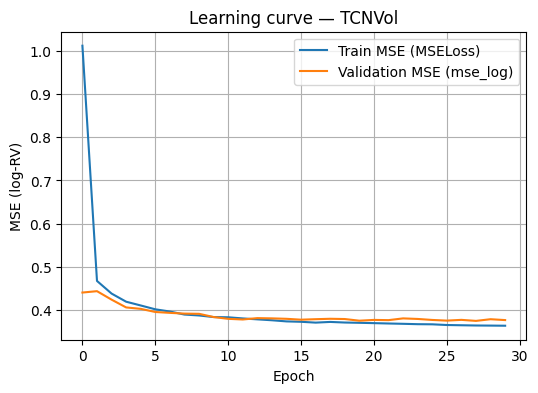

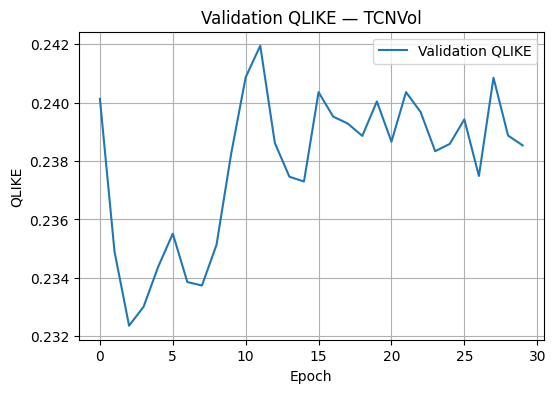

FINAL EVALUATION : TEST SET — TCNVol: MSE=0.367512 | QLIKE=0.244221

==================== Training GatedTCNVol ====================
Training samples: 89772
Validation samples: 19237

SUMMARY — GatedTCNVol
Best validation MSE: 0.394953 at epoch 27


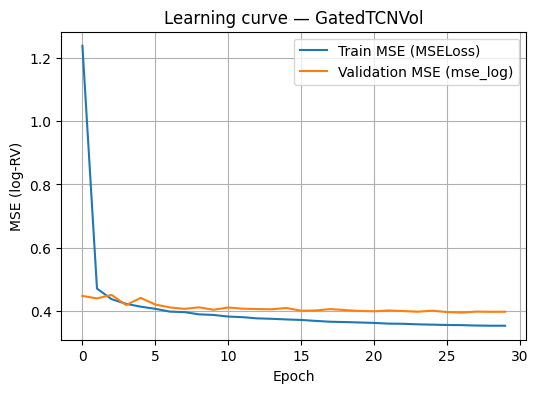

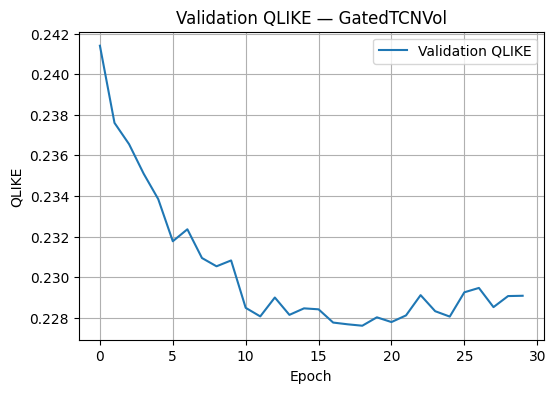

FINAL EVALUATION : TEST SET — GatedTCNVol: MSE=0.403803 | QLIKE=0.236355

==================== Training TCNVolAttPool ====================
Training samples: 89772
Validation samples: 19237

SUMMARY — TCNVolAttPool
Best validation MSE: 0.394902 at epoch 29


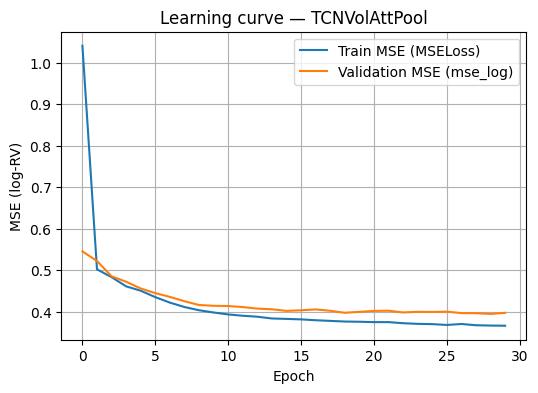

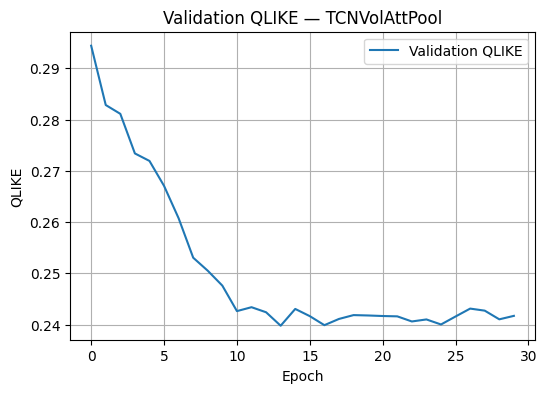

FINAL EVALUATION : TEST SET — TCNVolAttPool: MSE=0.404482 | QLIKE=0.247662

==================== Training ConvGRUAttVol ====================
Training samples: 89772
Validation samples: 19237

SUMMARY — ConvGRUAttVol
Best validation MSE: 0.382685 at epoch 23


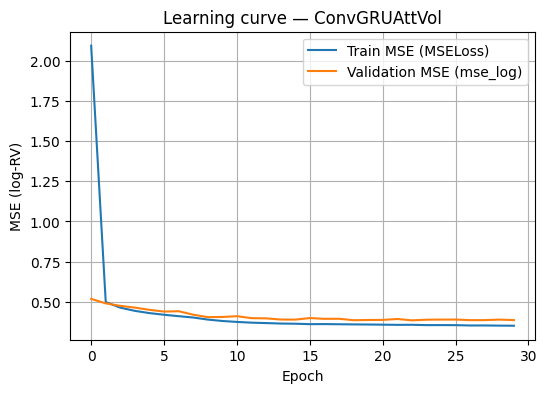

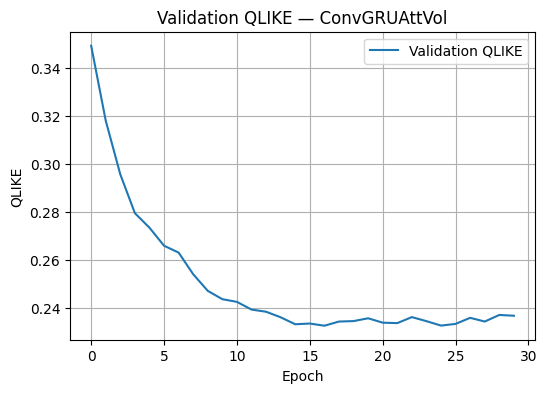

FINAL EVALUATION : TEST SET — ConvGRUAttVol: MSE=0.386904 | QLIKE=0.239867


In [ ]:
models_dict = {
    "TCNVol": TCNVol(n_features=X_train.shape[2], channels=(32,32,32), kernel_size=3, dropout=0.1),
    "GatedTCNVol":GatedTCNVol(n_features=X_train.shape[2], channels=(32,32,32), kernel_size=3, dropout=0.1),
    "TCNVolAttPool": TCNVolAttPool(n_features=X_train.shape[2], channels=(32,32,32), kernel_size=3, dropout=0.1),
    "ConvGRUAttVol": ConvGRUAttVol(n_features=X_train.shape[2], conv_channels=32, kernel_size=3, dilation=1,
                                    gru_hidden=64, gru_layers=1, dropout=0.1),
}
histories, summary_df = run_models(
    models_dict, train_loader, val_loader, test_loader,
    n_epochs=30, lr=1e-3, save_dir="checkpoints", plot_curves=True
)



In [ ]:
all_results = pd.DataFrame(columns=["MSE", "QLIKE"])

# Add HAR / GARCH

all_results.loc["HAR"]   = [float(summary["HAR_MSE"]),   float(summary["HAR_QLIKE"])]
all_results.loc["GARCH"] = [float(summary["GARCH_MSE"]), float(summary["GARCH_QLIKE"])]

# Add baseline DL

all_results = pd.concat([all_results, results_df[["MSE","QLIKE"]]], axis=0)

# 3) Add sophisticated DL

deep4 = summary_df.set_index("model")[["test_mse", "test_qlike"]].rename(
    columns={"test_mse": "MSE", "test_qlike": "QLIKE"}
)
all_results = pd.concat([all_results, deep4], axis=0)

all_results = all_results.sort_values(["QLIKE", "MSE"])
display(all_results)

,MSE,QLIKE
HAR,0.301543,0.201952
GatedTCNVol,0.403803,0.236355
GARCH,0.384542,0.237512
ConvGRUAttVol,0.386904,0.239867
TCNVol,0.367512,0.244221
TCNVolAttPool,0.404482,0.247662
LSTM,0.612188,0.258820
MLP,0.626725,0.370801


## Results summary

The results highlight a clear hierarchy between models.
Classical baselines remain strong: HAR-RV achieves the best overall performance on both MSE and QLIKE, confirming the importance of multi-horizon persistence in volatility dynamics.
Among deep learning models, TCN-based architectures (TCNVol, GatedTCNVol, ConvGRUAttVol) substantially outperform simpler neural baselines (MLP, LSTM), showing that causal convolutions and temporal inductive biases are crucial for volatility forecasting.
Attention mechanisms provide marginal gains but do not systematically dominate simpler causal convolutions.
Overall, the results suggest that architecture matters more than model complexity, and that DeepVol-inspired designs successfully bridge econometric intuition and deep learning.

# BONUS : PLOTTING FORECASTED VS TRUE VOLATILIY

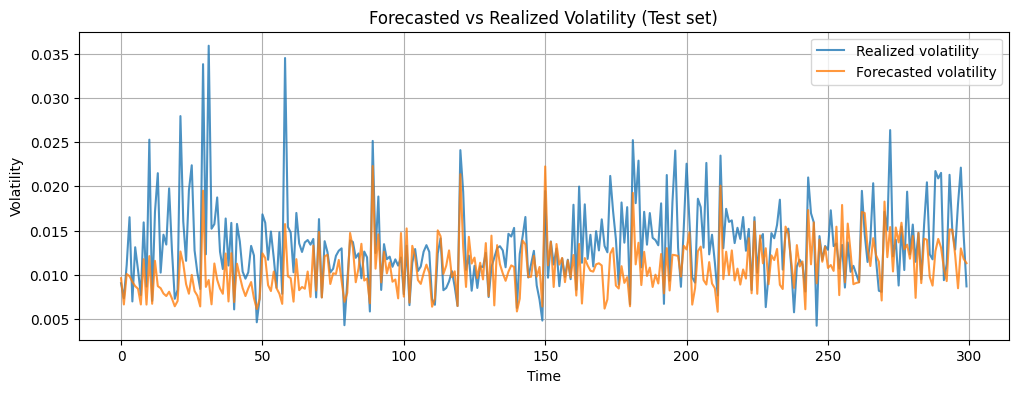

In [ ]:
#Mutliply by 1/2 to obtain the volatility
rv_true = np.exp(0.5*y_true)
rv_pred = np.exp(0.5*y_pred)

plt.figure(figsize=(12,4))
plt.plot(rv_true[:300], label="Realized volatility", alpha=0.8)
plt.plot(rv_pred[:300], label="Forecasted volatility", alpha=0.8)
plt.legend()
plt.title("Forecasted vs Realized Volatility (Test set)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()
